# Welcome to the Yolov8 Tutorial
- **Student:** Moritz Steinhauser ([e1622498@student.tuwien.ac.at](e1622498@student.tuwien.ac.at))
- **Author:** Esteve Valls Mascaro ([esteve.valls.mascaro@tuwien.ac.at](esteve.valls.mascaro@tuwien.ac.at))
- Advanced Robot Learning: Robot Scene Understanding


In [1]:
api_key = "vJ6CPnfOVIOXugejwTfz" # ROBOFLOW API. You need to create an accound and paste here your API to access the dataset!

## Setup!
In this tutorial we will learn in depth how the YOLOv8 object detector model works and how to train it from scratch. To better understand the underlying difficulties of efficiently training the model, we will make use of our own training and testing scripts, but you can find an highly-tuned implementation in [Ultralytics](https://github.com/ultralytics/ultralytics).

In [2]:
USE_COLAB = False

In [3]:
# %pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
Setup complete  (16 CPUs, 31.7 GB RAM, 354.7/951.6 GB disk)


#### Let's test out the pretrained model!

First, let's download an image of our [Autonomous Systems Lab](https://www.tuwien.at/en/etit/ict/asl).

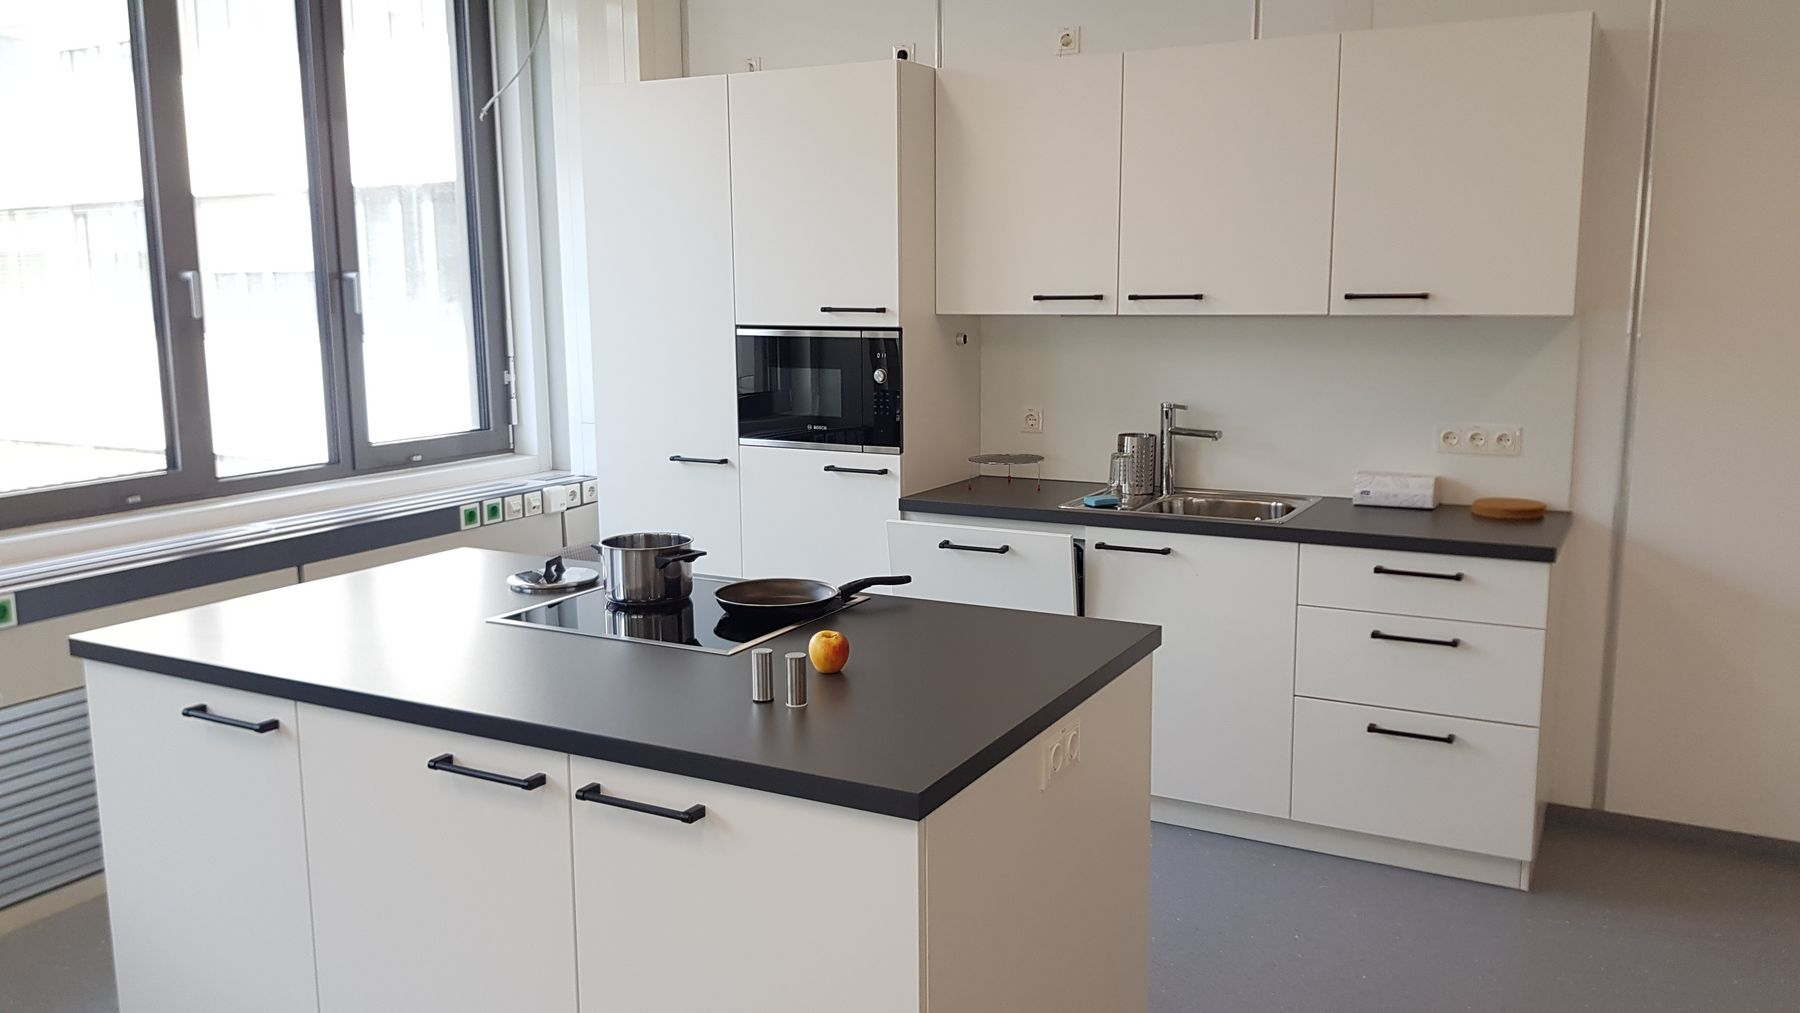

In [4]:
if USE_COLAB: 
    from google.colab import files as FILE
else:
    from IPython.display import Image
 
import os
import requests

DownURL = "https://www.tuwien.at/index.php?eID=dumpFile&t=p&p=2475366&token=62628c668a5dad2134acc2519f133134ece6002c"
filename = 'aslab.jpg'

img_data = requests.get(DownURL).content
with open(filename, 'wb') as handler:
    handler.write(img_data)

Image(filename, width=640, height=480)


Now, let's run the pre-trained YOLOv8 model (we use here the *small* version as we prioritize high speed). Other versions are available that can improve the accuracy (big or huge) but come up with a decrease in speed. Finding the right balance is key in real-world robotics applications as ours.

You can test different versions by changing the model=$MODEL
to: `yolov8n.pt yolov8s.pt yolov8m.pt yolov8l.pt yolov8x.pt`

In [5]:
# Run inference on an image with YOLOv8s
!yolo predict model=yolov8s.pt source=$filename

Ultralytics YOLOv8.0.196  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

WARNING  NMS time limit 0.550s exceeded
image 1/1 c:\Users\morit\Documents\Advanced_Robot_Learning\Detection\aslab.jpg: 384x640 1 orange, 1 oven, 155.1ms
Speed: 10.3ms preprocess, 155.1ms inference, 635.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict7
 Learn more at https://docs.ultralytics.com/modes/predict


One can see the predicted image in the generated folder : runs/detect/predict. If the following line does not work, that means you run the above command several times. Solve that by readapt the path based on the upper comment from Yolo ("Results saved to ...").

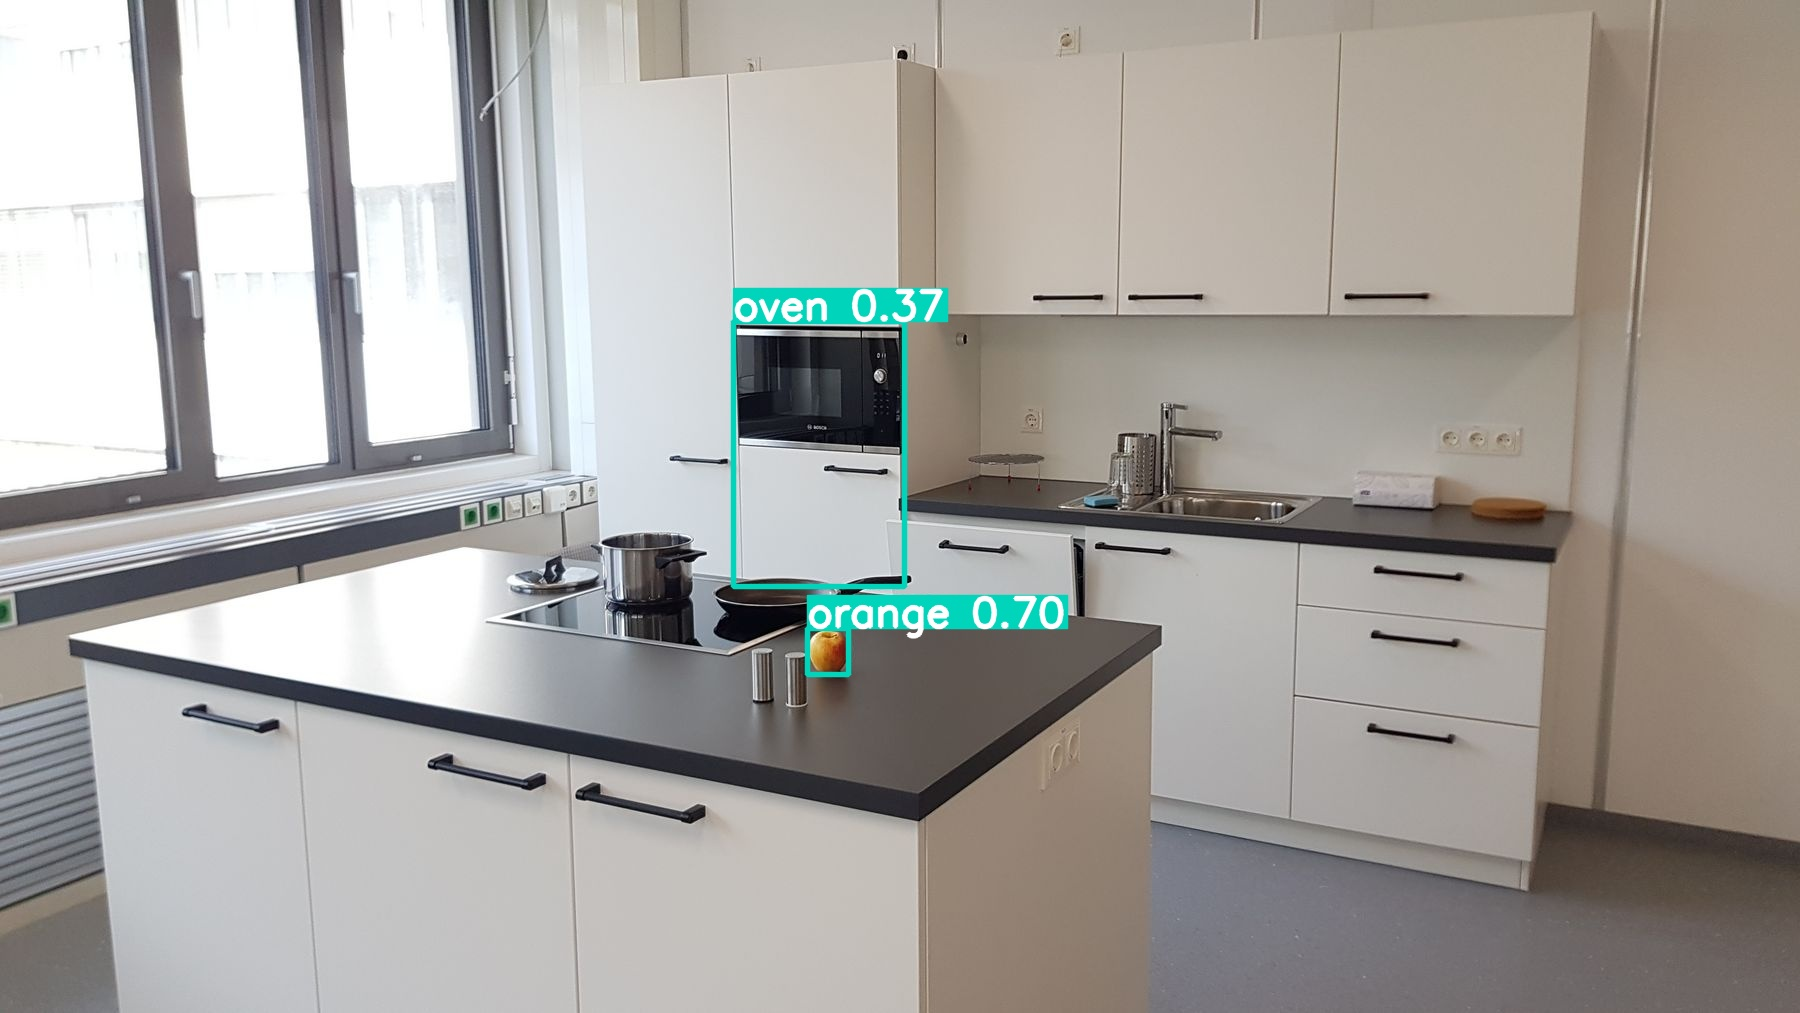

In [6]:
if USE_COLAB: 
    default_path = "/content"
else: 
    default_path = %pwd
results_path = f"{default_path}/runs/detect/predict/{filename}"
Image(results_path, width=640, height=480)

## Load our dataset! Download the BeerBottle dataset in Yolov8 Format.
If we are using the Dataset from RoboFlow, please follow the next steps in order to obtain the dataset: https://app.roboflow.com/

More information on how to create your own dataset [here](https://docs.ultralytics.com/es/datasets/#steps-to-contribute-a-new-dataset)

In [26]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("arl-vdrym").project("robotfetchmeadrink")
version = project.version(3)
roboflow_dataset = version.download("yolov8")
default_path = %pwd


loading Roboflow workspace...
loading Roboflow project...


After downloading the dataset, it is important to change the test train and validation paths to be adequate with colab! For that, go inside the data.yaml file and update the paths, from:


```
test: ../test/images
train: RobotFetchMeADrink-3/train/images
val: RobotFetchMeADrink-3/valid/images formato de código
```


To:

```
test: test/images
train: train/images
val: valid/images
```



## Explore the dataset with Ultralytics: loading annotations and augmentations
  The following code is in charge of understanding the intrinsics of how YOLO loads and augments the images in order to recognize the improvements of the last years. While desigining *efficient architectures* is important, engineering *novel augmentations and data loading techniques* is also relevant to improve performance.


##### Preparation
First we define the training class from YOLO Detection to train models.
This class is specific from Ultralytics but is in charge of managing the Training from the models. Tasks:

*   Handling the configuration files (see trainer.args)
*   Building the model: this is done through the trainer.setup_model()
*   Loading the dataset according to the configuration files.



In [8]:
# Set up DetectionTrainer with default configuration files (see trainer.args)
from ultralytics.models.yolo.detect import DetectionTrainer
args = dict(model='yolov8n.pt', data=f"{default_path}/RobotFetchMeADrink-3/data.yaml", epochs=3)
trainer = DetectionTrainer(overrides=args)

Ultralytics YOLOv8.0.196  Python-3.12.3 torch-2.3.0+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\morit\Documents\Advanced_Robot_Learning\Detection/RobotFetchMeADrink-3/data.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes

In [9]:
# Load a pretrained YOLO model (see args for more information),
# but readapt the final Detection Layer to account for the new dataset type.
# In this case, different number of weights!
weights = trainer.setup_model()

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [10]:
# Load the dataset for mode="train" (in charge of retrieving the images and perform augmentation) and the dataloader to iteratively extract those as a dictionary
from ultralytics.utils.torch_utils import de_parallel, torch_distributed_zero_first
from ultralytics.data import build_dataloader, build_yolo_dataset

mode="train"
shuffle = False # To avoid shuffling for always showing same paths in train and val! mode == "train"
rank = -1 # We assume we do not have parallel training: set to 0 if you have
batch_size = trainer.batch_size
with torch_distributed_zero_first(rank):  # init dataset *.cache only once if DDP
  training_dataset = trainer.build_dataset(trainer.trainset, mode, batch_size)
  validation_dataset = trainer.build_dataset(trainer.trainset, "val", batch_size)

workers = trainer.args.workers if mode == "train" else trainer.args.workers * 2

train_dataloader = build_dataloader(training_dataset, batch_size, workers, shuffle, rank)  # return dataloader
val_dataloader = build_dataloader(validation_dataset, batch_size, workers, False, rank)  # return dataloader

train: Scanning C:\Users\morit\Documents\Advanced_Robot_Learning\Detection\RobotFetchMeADrink-3\train\labels.cache... 7084 images, 4 backgrounds, 0 corrupt: 100%|██████████| 7084/7084 [00:00<?, ?it/s]
train: WARNING  C:\Users\morit\Documents\Advanced_Robot_Learning\Detection\RobotFetchMeADrink-3\train\images\image_1_166_jpg.rf.b187e2c02a9494b2e551ae1e656d195e.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\morit\Documents\Advanced_Robot_Learning\Detection\RobotFetchMeADrink-3\train\images\image_1_166_jpg.rf.bcb69a996d11981d68a219a9cda2346a.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 1908, len(boxes) = 27648. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
val: Scanning C:\Users\morit\Documents\Advanced_Robot_Learning\Detection\RobotFetchMeADrink-3\train\labels.cache... 7084 images, 4 backgroun

##### Visualization
Check the images and how the augmentations affect those.

In [11]:
batch_train  = next(iter(train_dataloader))  # Extract the batch from the training dataset, with the augmentations already performed
batch_val = next(iter(val_dataloader)) # Extract the batch from the validation dataset, without augmentations as it comes from the validation set
print(batch_train.keys())

dict_keys(['im_file', 'ori_shape', 'resized_shape', 'img', 'cls', 'bboxes', 'batch_idx'])


Check the training images, with augmentations!

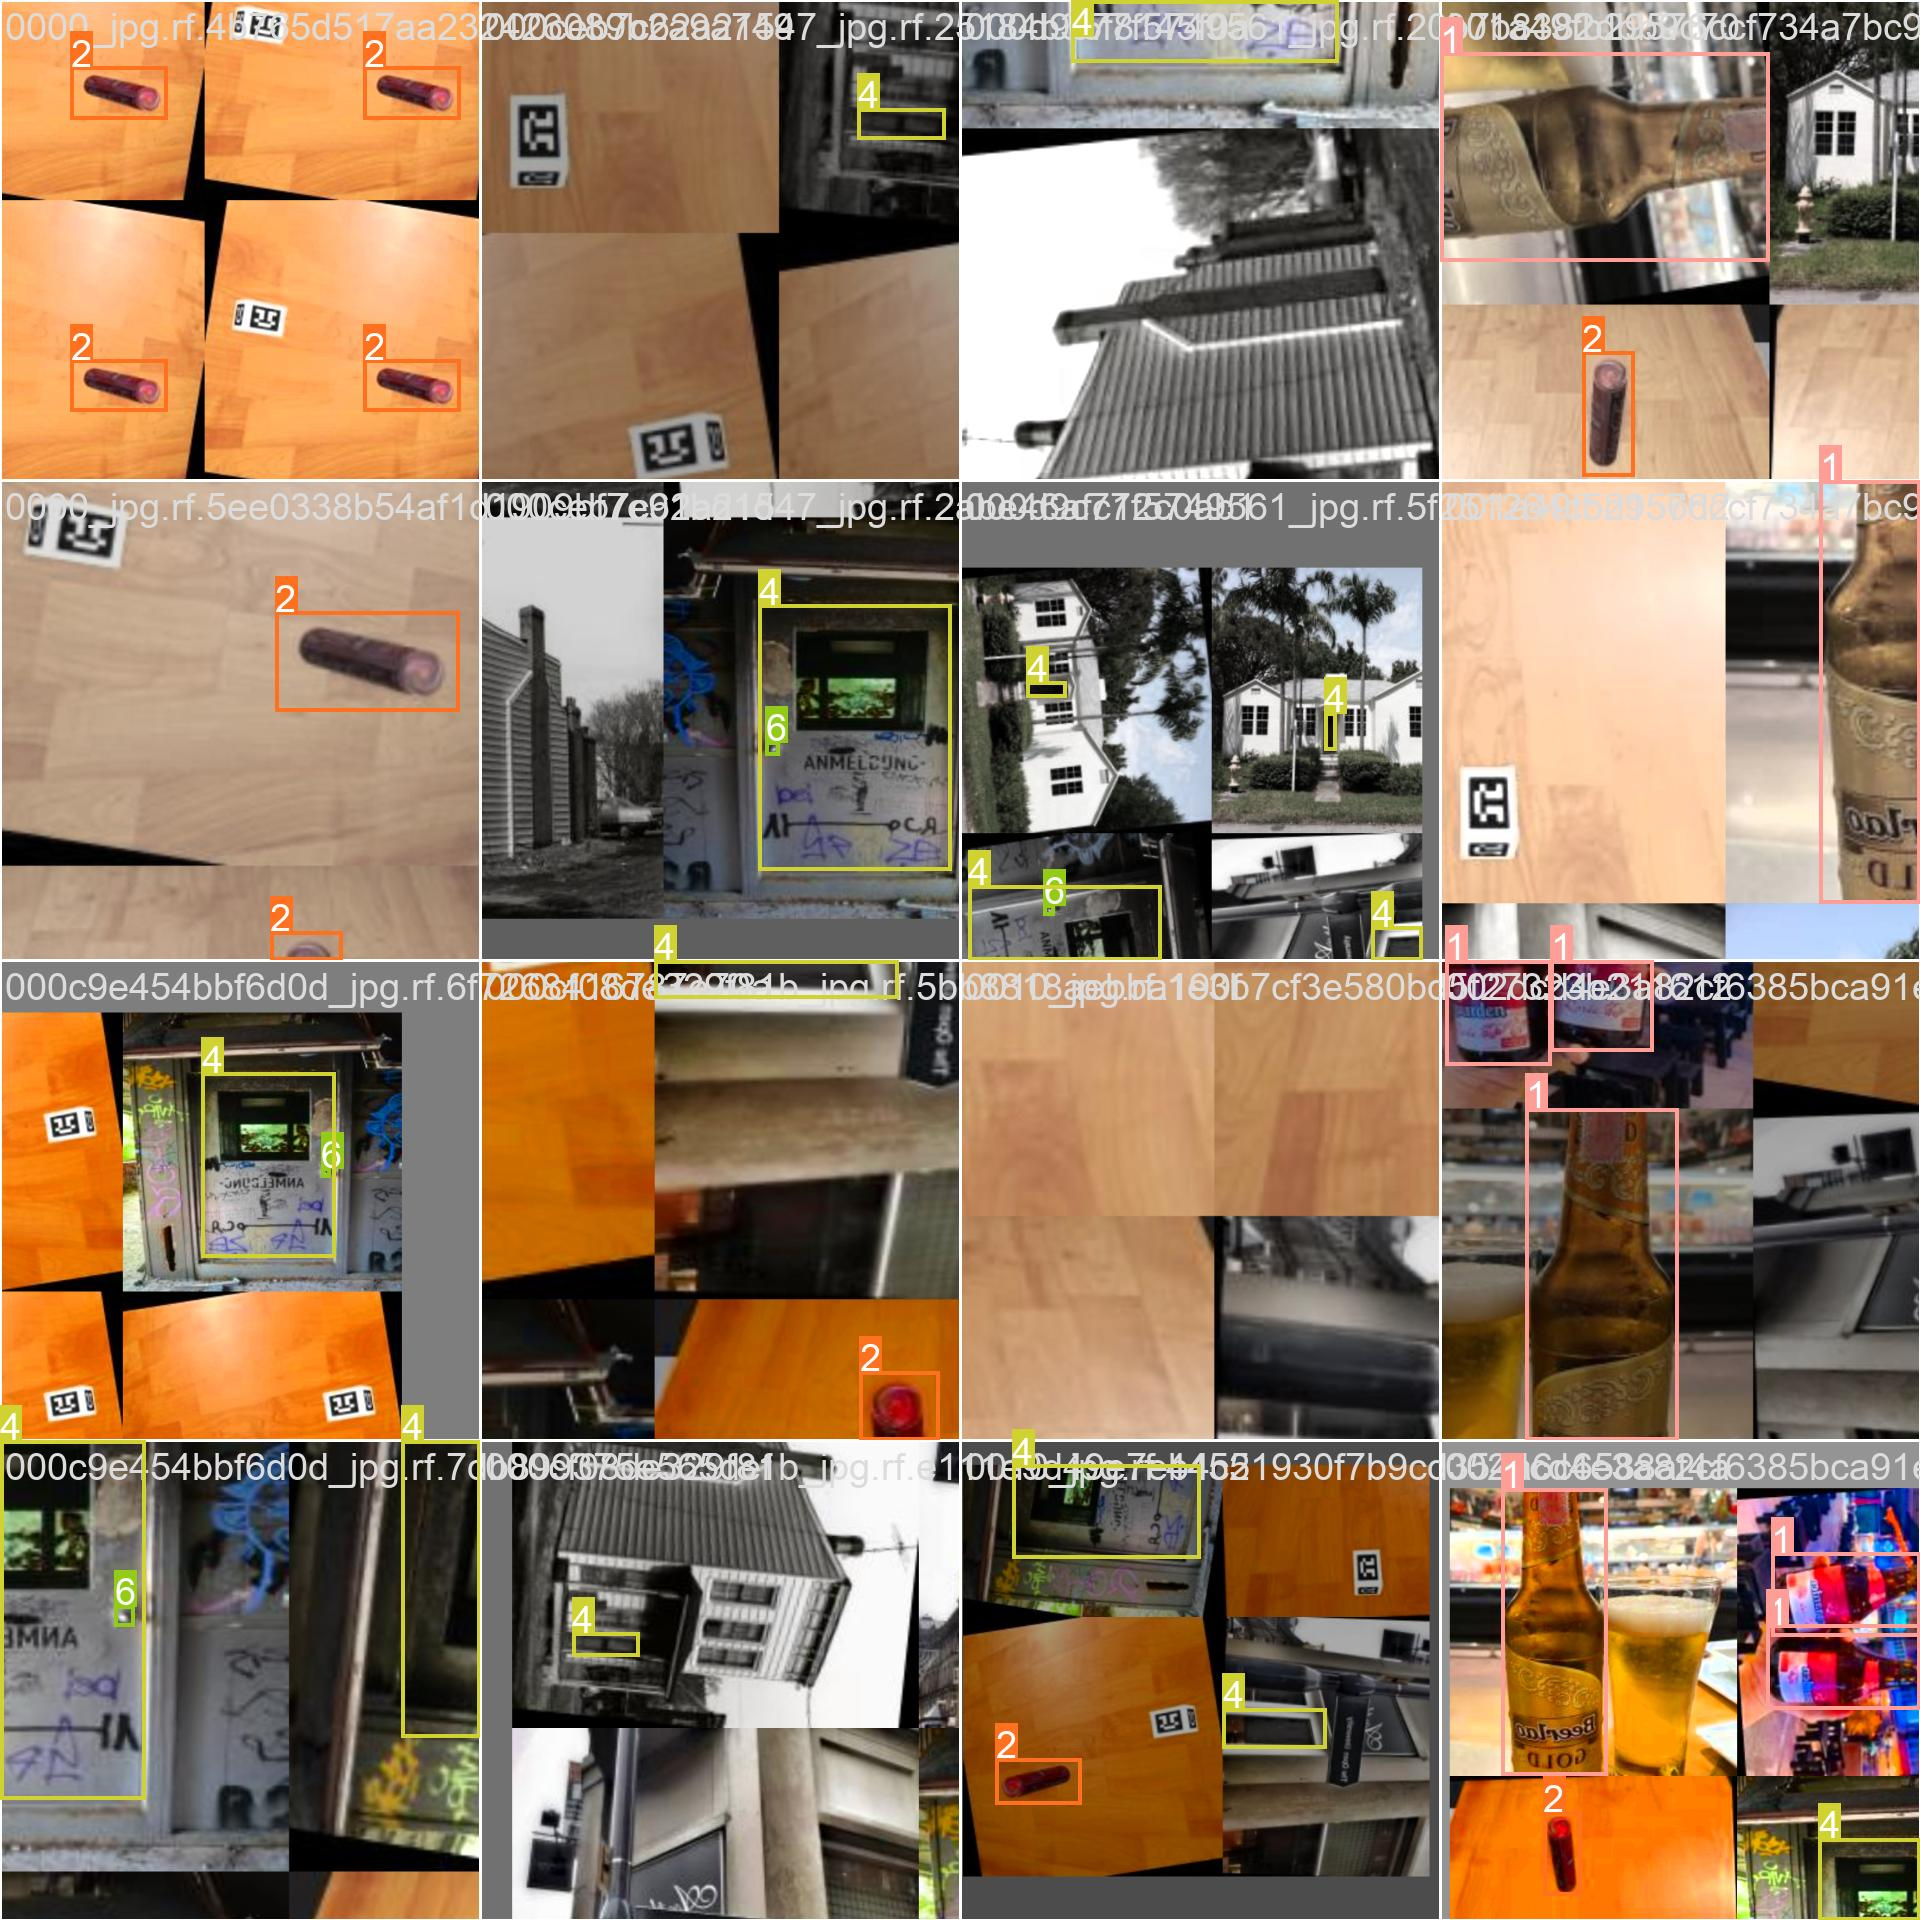

In [12]:
trainer.plot_training_samples(batch_train, 0) # Given the extracted batch, plot the augmented images
results_path = f"{default_path}/runs/detect/train2/train_batch0.jpg" # If you find an error, go to /runs/ and see which id X to add here trainX
Image(results_path, width=640, height=480)


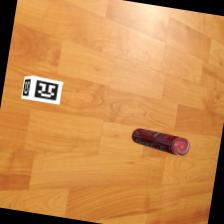

In [13]:
# To see the original image without augmentation, make use of :
idx = 0
Image(batch_train["im_file"][idx], width=640, height=480)

Check the validation images, without augmentations!

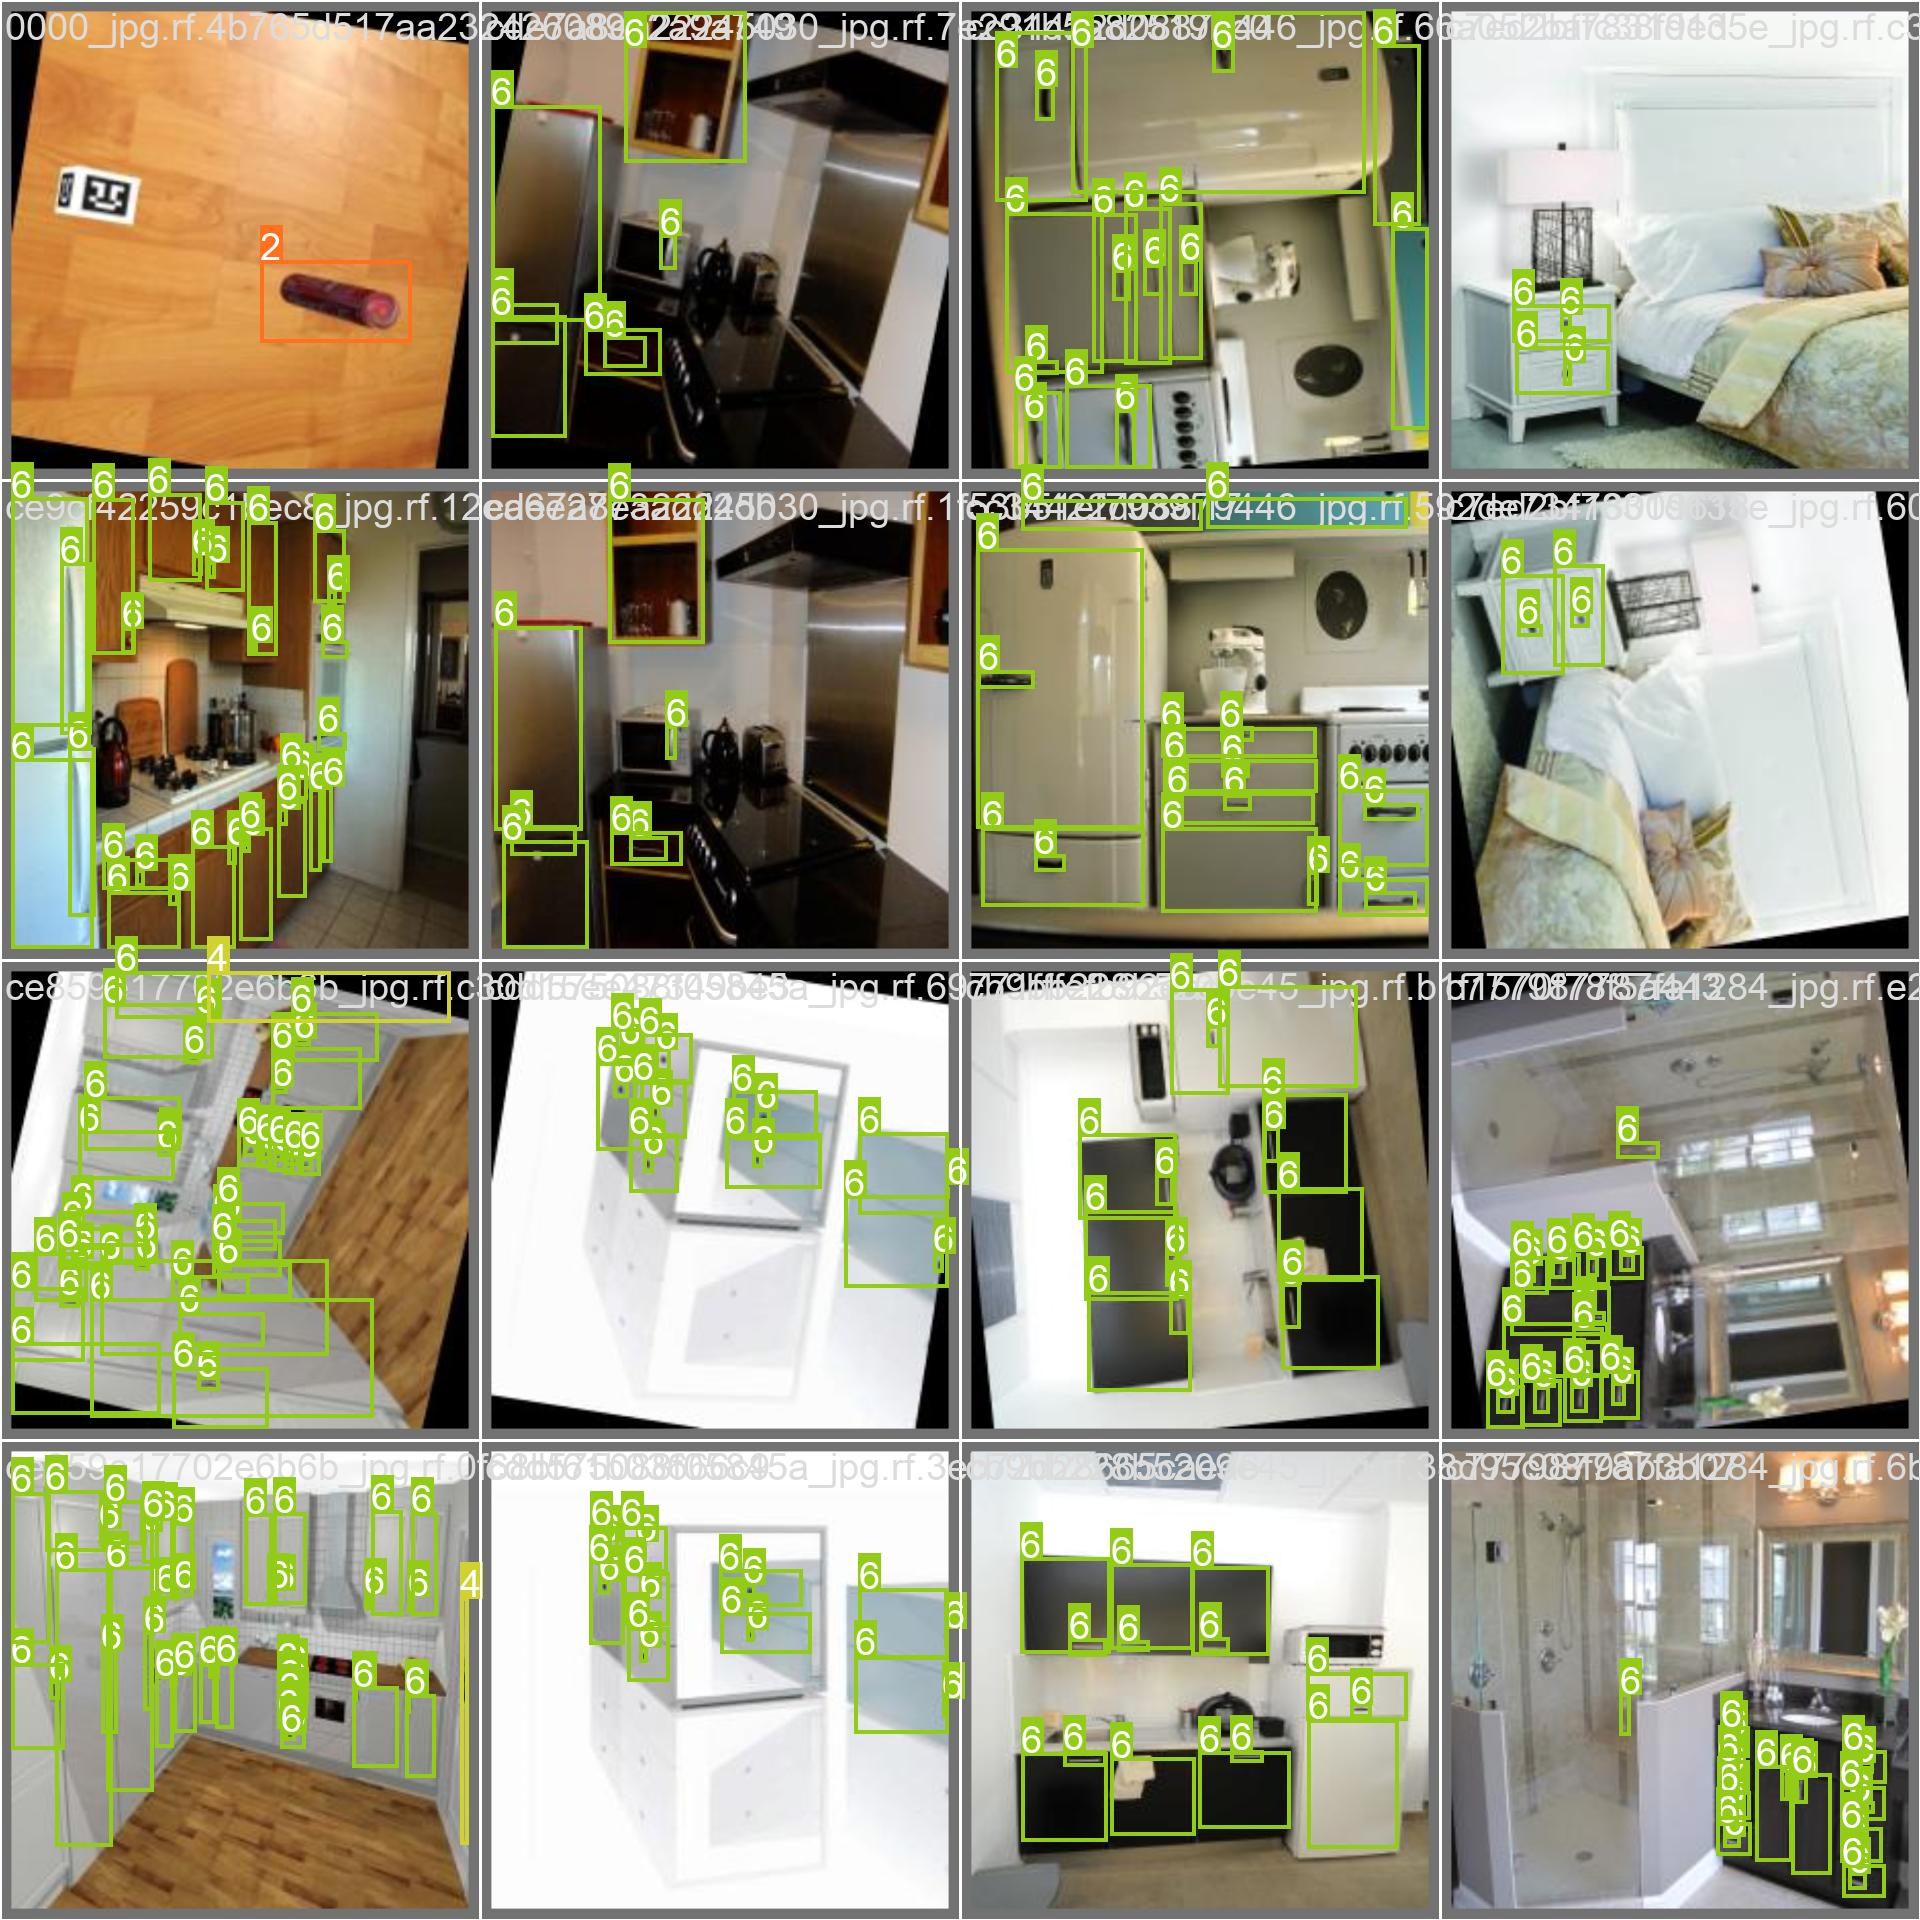

In [14]:
trainer.plot_training_samples(batch_val, 1) # Given the extracted batch, plot the augmented images
results_path = f"{default_path}/runs/detect/train2/train_batch1.jpg"
Image(results_path, width=640, height=480)

## Train your custom model!

### Build the Yolov8 model
To efficiently learn new objects while not requiring large scale annotated data of the new objects, we make use of the **transfer learning** technique. Transfer Learning allows to extract robust features from large scale data that improve generalization and decrease the computational training costs.

For that, we train a deep learning architecture by fine-tuning pre-trained weights. In this case, we will make use of the *YOLOv8 trained on COCO dataset*.


You can learn more on Transfer Learning [here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/).

In [27]:
# load a pretrained YOLOv8n detection model.
from ultralytics import YOLO

import torch.nn as nn

class YoloWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        yolowrapper = YOLO('yolov8n.pt') # As we want to train from scratch, we extract only the NN architecture, without additional functions
        self.model = yolowrapper.model.model

    def forward(self, imgs):
        return self.model.predict(imgs)

model = YoloWrapper()
        


By setting the  ``` visualize_model_layers=True ``` one can visualize the Sequential Modules that conform the YOLO architecture. We can observe the simplicity of the network layers, which are mainly formed out of three basic blocks:


*   **2D Convolutional Networks**: Learns how to extract relevant features from grid data, with a given kernel, stride and padding
*   **2D Batch Normalization**: provides stability in the training while reducing overfitting
*   **SiLU**: Activation function

Other layer types used are:
*   **Concat**: used to concatenate features at different scales and resolutions (with a simillar approach to the skipping connections found in ResNet or UNet)
*   **Upsample**: to extend the feature size. In this case, repeating the 'nearest' feature vector and scaling the size by scale_factor=2.0

In [16]:
visualize_model_layers = True
if visualize_model_layers:
  print(model)

YoloWrapper(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (

### Define the Dataset Classes

In [28]:
dataset_cfg = f"{default_path}/RobotFetchMeADrink-3/data.yaml"

#### Definition of helper classes

In [29]:
import yaml

def load_yaml(file_path):
  # Open the file and load the YAML content
  with open(file_path, 'r') as file:
      yaml_content = yaml.safe_load(file)
  return yaml_content

In [30]:
data_cfg = load_yaml(dataset_cfg)
data_cfg.keys()

dict_keys(['train', 'val', 'test', 'nc', 'names', 'roboflow'])

#### Create Transformations (and augmentations)!

In [31]:
import torch
import numpy as np
from torchvision.transforms import v2
import torchvision.transforms as T
from torchvision import tv_tensors

class UnNormalize(object):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
        
class MyRandomHorizontalFlip(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        self.hflip = v2.RandomHorizontalFlip(p=p)
    def forward(self, img, bboxes):
        img_out, bboxes_out = self.hflip(img, bboxes)
        return img_out, bboxes_out
        
def augmentations_transforms():
    augmentation = v2.Compose(
        [
            v2.RandomApply(
                [v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                 v2.RandomRotation(degrees=(-10, 10))
                 ],
                p=0.5,
            ),
            MyRandomHorizontalFlip(p=0.5),
            v2.RandomApply(
                [v2.GaussianBlur(kernel_size=3)],
                p=0.2,
            )
        ]
    )
    return augmentation

def get_transforms(img_size=480, with_augmentation=False):
    if with_augmentation:
        return v2.Compose([
            v2.Resize(img_size, interpolation=T.InterpolationMode.BICUBIC),
            v2.CenterCrop(img_size),
            v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
            v2.ToDtype(torch.float32, scale=True),
            augmentations_transforms(),
            v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    return v2.Compose([
        v2.Resize(img_size, interpolation=T.InterpolationMode.BICUBIC),
        v2.CenterCrop(img_size),
        v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

#### Load data

In [32]:
import tqdm
import numpy as np
import cv2
from copy import deepcopy
import math
import torch
from PIL import Image as ImagePIL

dataset_path = f'{default_path}/RobotFetchMeADrink-3/'

class Dataset:
    def __init__(self, dataset_path, cfg_data, mode="train", imgsz=224):
        self.names = cfg_data["names"]
        self.nc = cfg_data["nc"]
        self.imgsz=imgsz
        self.mode = mode
        self.transform = get_transforms(imgsz, mode =="train")
        self.data_path = f'{dataset_path}/{cfg_data[self.mode]}'
        self.annotations = self.prepare_data()

    def read_labels(self, lb_file):
        if os.path.isfile(lb_file):
            with open(lb_file) as f:
                lb = [x.split()[:5] for x in f.read().strip().splitlines() if len(x)]
                lb = np.array(lb, dtype=np.float32)
            if len(lb) >0:
                return dict( 
                    cls=lb[:, 0:1],
                    bboxes=lb[:, 1:],
                    num_obj = len(lb)
                )
        return dict( 
                    cls=np.zeros((0, 1), dtype=np.float32),
                    bboxes=np.zeros((0, 4), dtype=np.float32),
                    num_obj = 0
                )

        
    def prepare_data(self):
        image_paths = os.listdir(self.data_path)
        annotations = []
        for img_path in tqdm.tqdm(image_paths):
            label_file = os.path.join(self.data_path.replace("images", "labels"), img_path.replace(".jpg", ".txt"))
            data = self.read_labels(label_file)
            data.update({"im_file": os.path.join(self.data_path, img_path), "normalized": True, "bbox_format": "xywh"})
            annotations.append(data)
        
        return annotations



    def cxcyhw2xyxy(self, cxcyhw):
        xyxy = np.zeros_like(cxcyhw)
        xyxy[:, 0] = cxcyhw[:, 0] - cxcyhw[:, 2]/2
        xyxy[:, 1] = cxcyhw[:, 1] - cxcyhw[:, 3]/2
        xyxy[:, 2] = cxcyhw[:, 0] + cxcyhw[:, 2]/2
        xyxy[:, 3] = cxcyhw[:, 1] + cxcyhw[:, 3]/2
        return xyxy

    
    def normalize_box(self, xyxy, orig_shape):
        """Return the boxes in xyxy format normalized by original image size."""
        xyxy[..., [0, 2]] /= orig_shape[1]
        xyxy[..., [1, 3]] /= orig_shape[0]
        return xyxy
    
    def unnormalize_box(self, xyxyn, orig_shape):
        """Return the boxes in xyxy format normalized by original image size."""
        xyxyn[..., [0, 2]] *= orig_shape[1]
        xyxyn[..., [1, 3]] *= orig_shape[0]
        return xyxyn

    def do_transformation(self, img, xyxyn , img_height, img_width):
        xyxy = self.unnormalize_box(xyxyn, (img_height, img_width))
        boxes = tv_tensors.BoundingBoxes(xyxy, format="XYXY", canvas_size=(img_height, img_width))
        out_img, out_boxes = self.transform(img, boxes)
        out_boxes = out_boxes.data.detach().cpu().numpy()
        out_boxes_norm = self.normalize_box(out_boxes.copy(), (self.imgsz, self.imgsz))
        return out_img, out_boxes.astype(int), out_boxes_norm

    def load_image(self, f, bboxes_frame):
        """Loads 1 image from dataset index 'i', returns (im, resized hw)."""
        frame = ImagePIL.open(f)
        w0, h0 = frame.size
        image, obj_bboxes, out_boxes_norm = self.do_transformation(frame, torch.from_numpy(self.cxcyhw2xyxy(bboxes_frame)), h0, w0)        
        return image, obj_bboxes, out_boxes_norm, (h0, w0), image.shape[:2]
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label = deepcopy(self.annotations[index])  # requires deepcopy() https://github.com/ultralytics/ultralytics/pull/1948
        label["img"], label["bboxes"],label["bboxes_norm"], label["ori_shape"], label["resized_shape"] = self.load_image(label["im_file"], label["bboxes"].copy())
        label["ratio_pad"] = (
            label["resized_shape"][0] / label["ori_shape"][0],
            label["resized_shape"][1] / label["ori_shape"][1],
        )  # for evaluation
        return label

    @staticmethod
    def collate_fn(batch):
        """Collates data samples into batches."""
        new_batch = {}
        keys = batch[0].keys()
        values = list(zip(*[list(b.values()) for b in batch]))
        for i, k in enumerate(keys):
            value = values[i]
            if k == "img":
                value = torch.from_numpy(np.stack(value, 0))
            elif k == "cls":
                value = torch.from_numpy(np.concatenate(value, 0))
            elif k == "bboxes":
                value = torch.from_numpy(np.concatenate(value, 0))
            elif k == "bboxes_norm":
                value = torch.from_numpy(np.concatenate(value, 0))
            elif k == "num_obj":
                batch_idx = []
                for j, v in enumerate(values[i]):
                    batch_idx.extend([j]*v)
                new_batch["batch_idx"] = torch.LongTensor(batch_idx)
            new_batch[k] = value
        return new_batch

In [37]:
from torch.utils.data import DataLoader

dataset = Dataset(dataset_path, data_cfg, "train")

loader = DataLoader(dataset,
                    batch_size=64,
                    num_workers=2,
                    collate_fn= dataset.collate_fn,
                    shuffle=True,
                    pin_memory=True,
                    drop_last=True)

100%|██████████| 7084/7084 [00:01<00:00, 3729.06it/s]


In [ ]:
# print(len(loader))
# data = next(iter(loader))
# print("done")
# data.keys()

#### Visualize data

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt

def draw_img(img, bboxes, cls, is_normalized=False):      
    for i, (box, label) in enumerate(zip(bboxes, cls)):
        img = cv2.rectangle(img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0,255,0) , 2)
        img = cv2.putText(img, f"{i}: {label[0]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    return img
    
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
def untransform_img(pil_image):
    #image_np = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    transf_back = T.Compose([
                UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                T.ToPILImage(),
            ])
    normalize_img = np.array(transf_back(pil_image).convert('RGB'))[:, :, ::-1].copy()

    return normalize_img

In [ ]:
# show_howmany = 3
# for batch_idx, img in enumerate(data["img"]):
#     img = untransform_img(img.clone())
#     obj_mask = data["batch_idx"] == batch_idx
#     bboxes = data["bboxes"][obj_mask]
#     cls = data["cls"][obj_mask]
#     new_img = draw_img(deepcopy(img), bboxes.detach().cpu().numpy(), cls.detach().cpu().numpy())
#     plt.imshow(new_img)
#     plt.show()
#     if batch_idx >= show_howmany -1:
#         break

## Train with YOLO - Ultralytics

In [39]:
!yolo task=detect mode=train model=yolov8s.pt data={roboflow_dataset.location}/data.yaml epochs=25 imgsz=224 plots=True device=0

^C


# Exercises: Test the results in real data!

In [40]:
USE_COLAB = False
if USE_COLAB: 
    default_path = "/content"
else: 
    default_path = %pwd

In [41]:
try: 
    roboflow_dataset
except:
    from roboflow import Roboflow
    rf = Roboflow(api_key=api_key)
    project = rf.workspace("arl-vdrym").project("robotfetchmeadrink")
    version = project.version(3)
    roboflow_dataset = version.download("yolov8")

##### Step 0. Describe the different metrics and results from the performed training!
At the end of the training loop, you should be able to see "Results saved to runs/detect/trainID. In my case, ID=5
Go to that directory and observe the different metrics graphs. Add some comments do explain those and give some feedback on how the results could be improved.


In [43]:
ID = 0 # here add your trainID directory

###### Step 0.1 Describe the Training and Validation Losses and Metrics

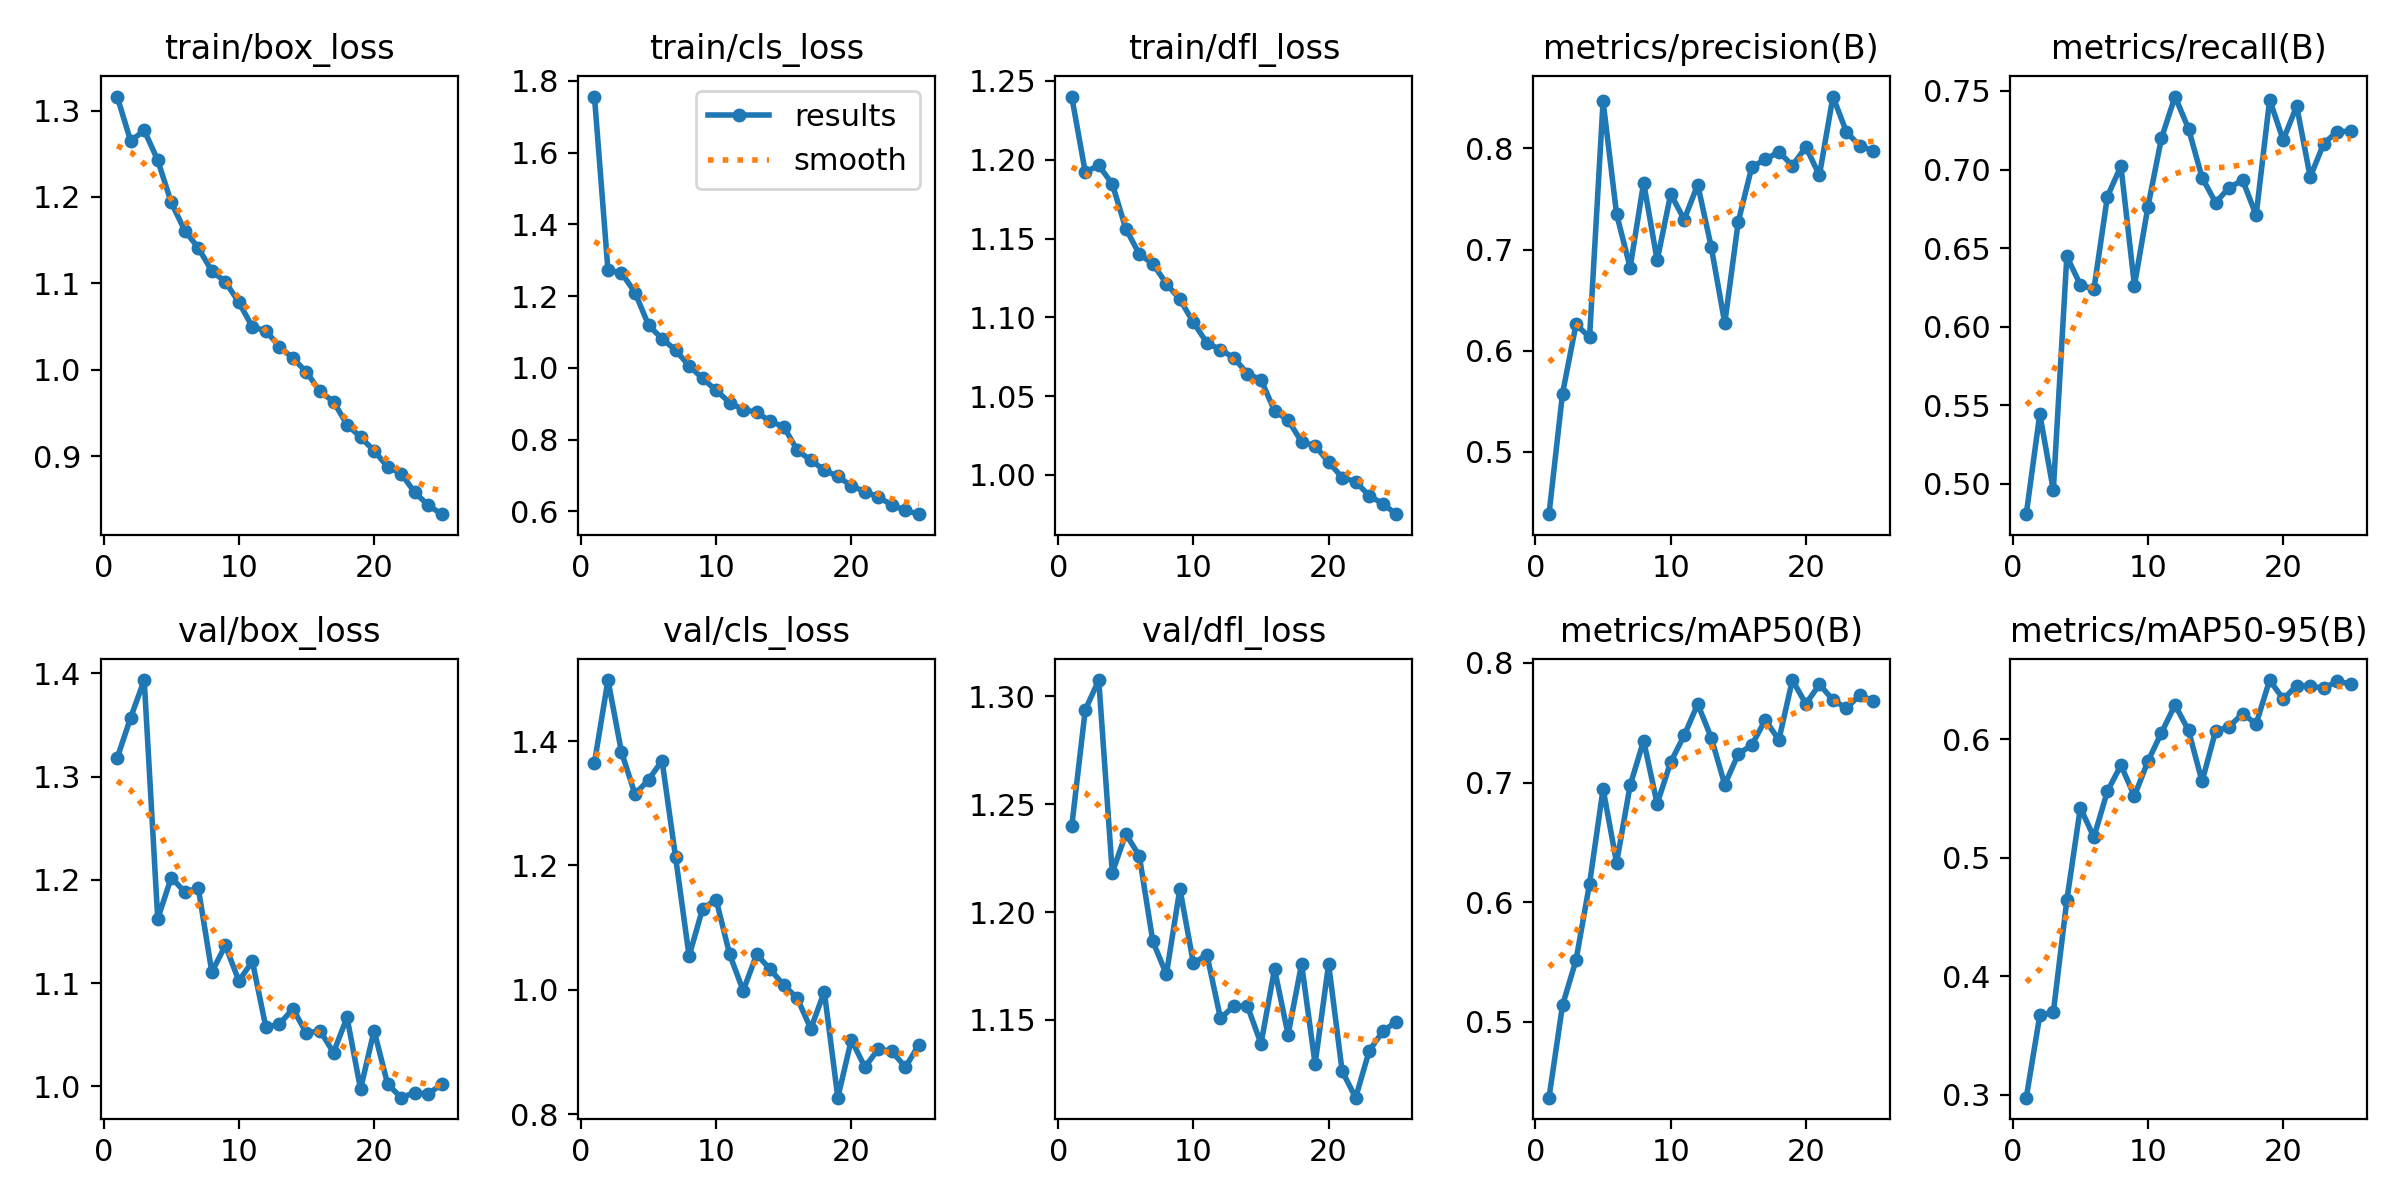

In [44]:
Image(f"{default_path}/runs/detect/train{ID}/results.png")

Add your comment here...

###### Step 0.2 Describe the F1 Curve and PR Curve. What do they indicate?
Apple, Cup and Orange have a high F1 value over a broad range of confidence which means that those classes will be better classified than the others. 
A high confidence threshold increases precision but decreases recall.
Door and Handle will be hard to detect by the model.

High Recall, Low Precision
On the right side of the curve, recall is high but precision tends to be low.
This means the model is capturing most of the actual positive instances (high recall), but it also includes many false positives (low precision).

High Precision, Low Recall
On the left side of the curve, precision is high but recall tends to be low.
This means the model is making fewer false positive errors (high precision), but it is missing many actual positive instances (low recall).

For classes like "Cup" and "Apple", the curves are closer to the top right corner, indicating both high precision and recall, which suggests robust performance.
For classes like "Door" and "Handle", the precision drops steeply as recall increases, showing a significant trade-off and difficulty in maintaining high precision when trying to achieve high recall.

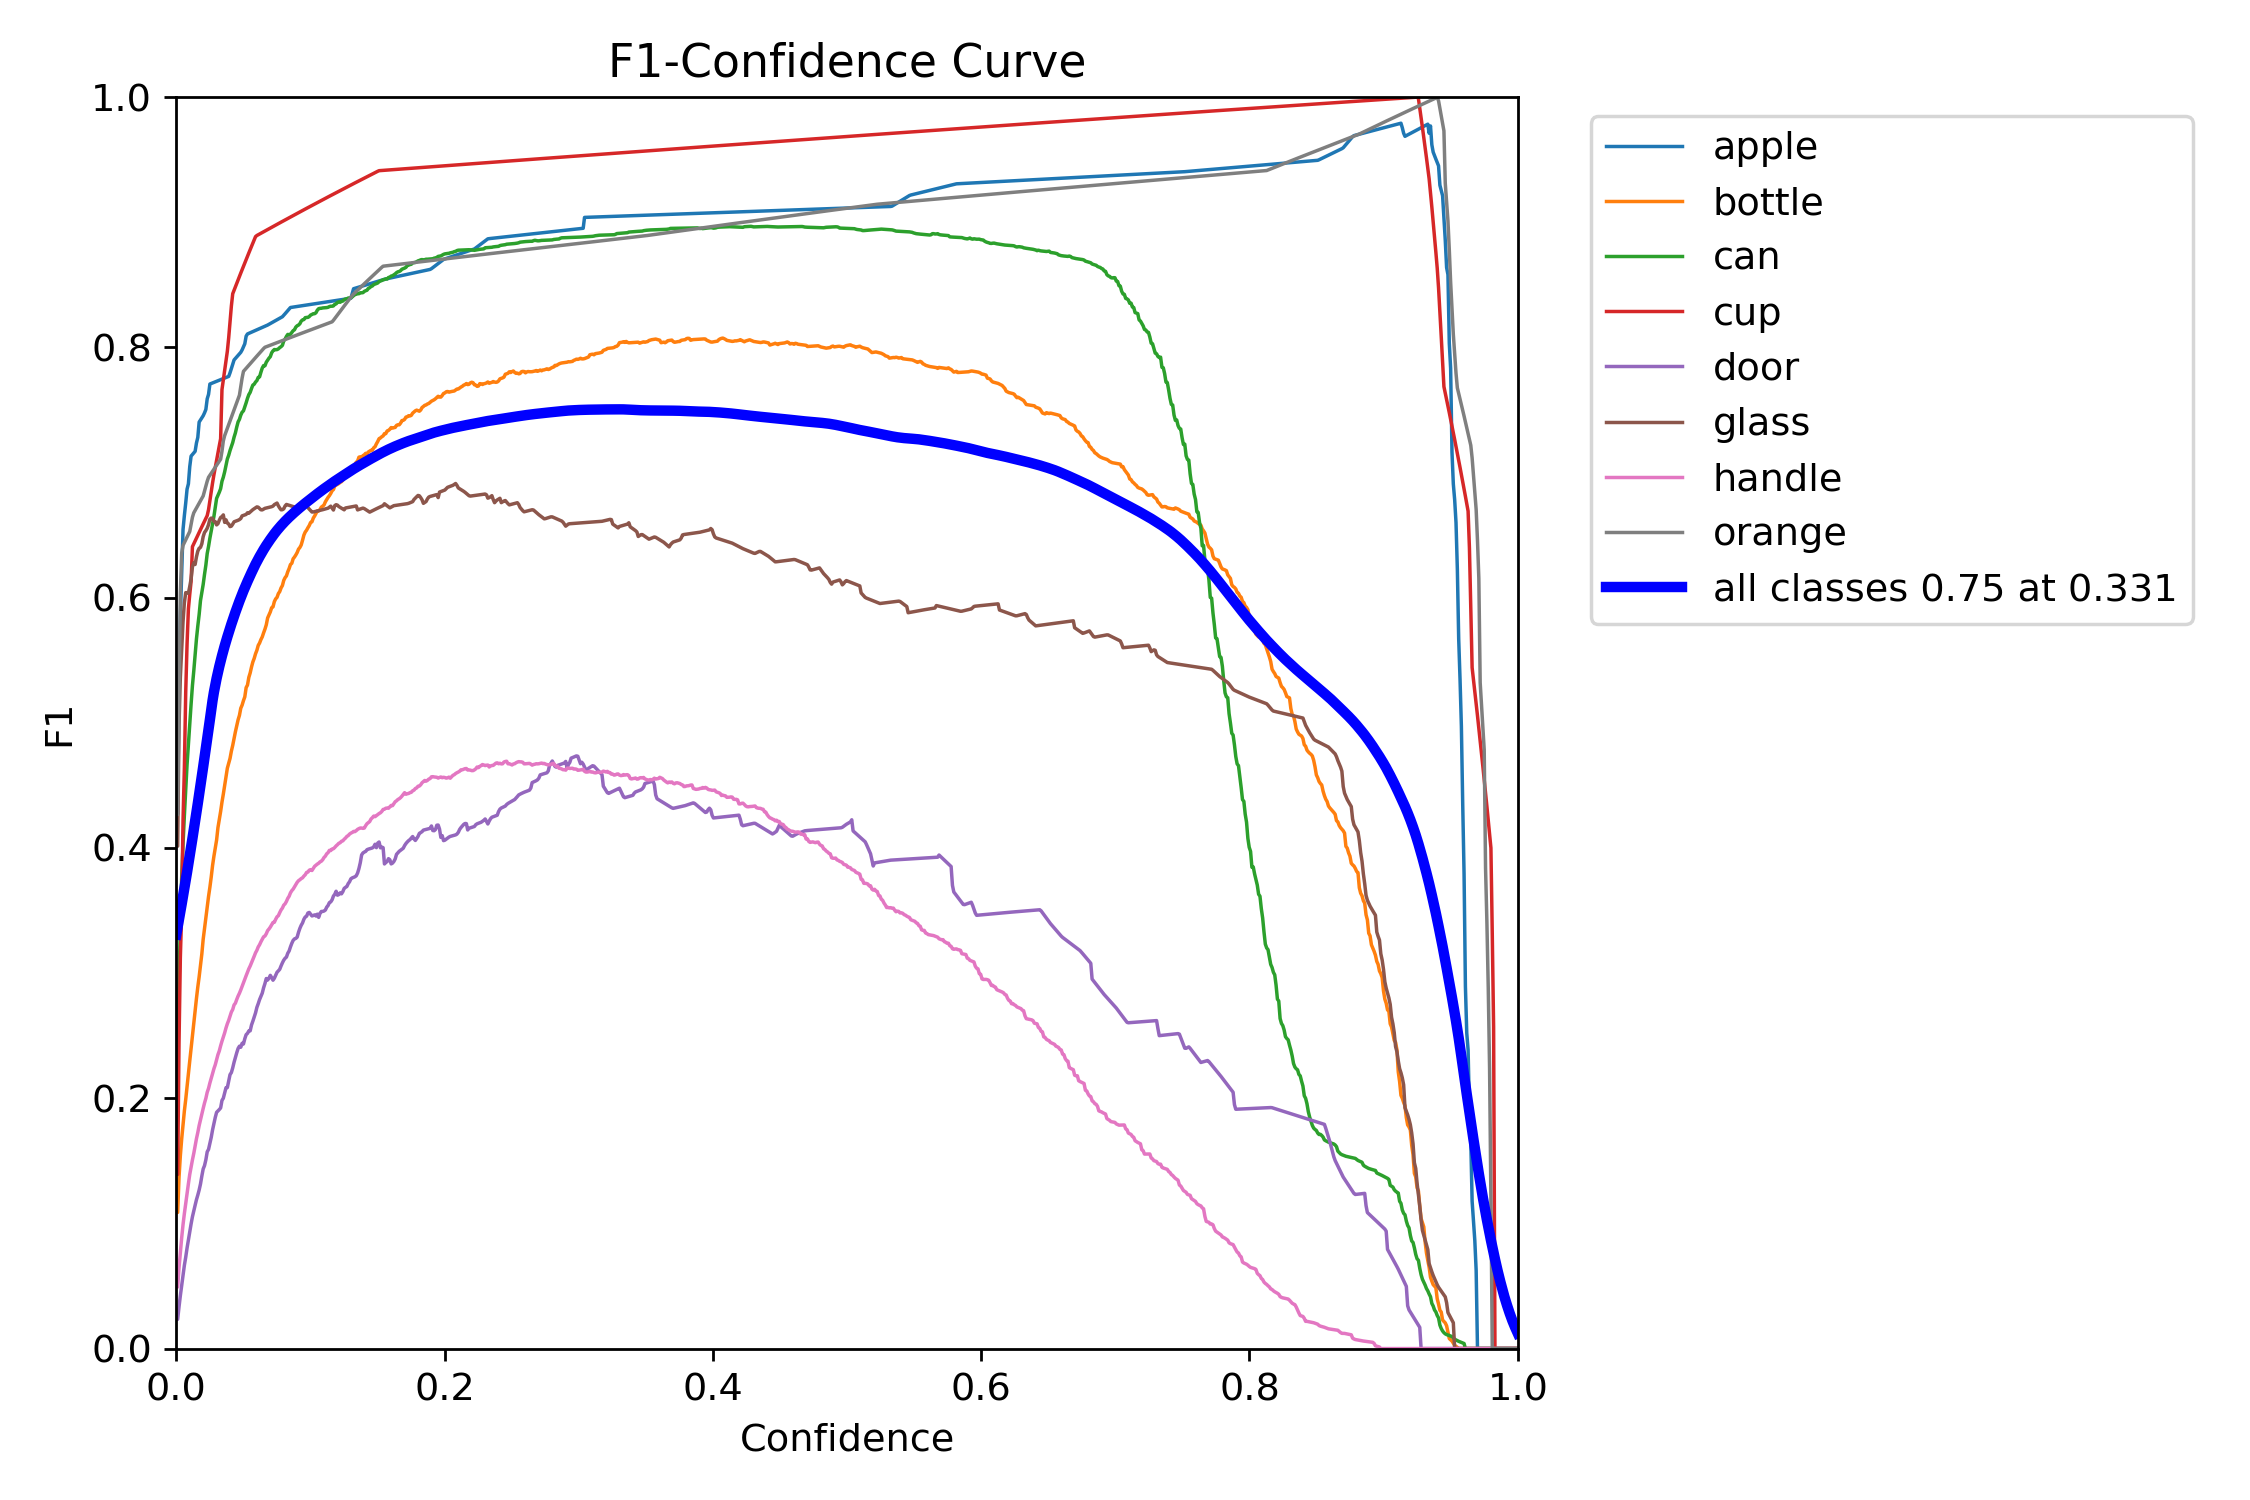

In [45]:
Image(f"{default_path}/runs/detect/train{ID}/F1_curve.png")


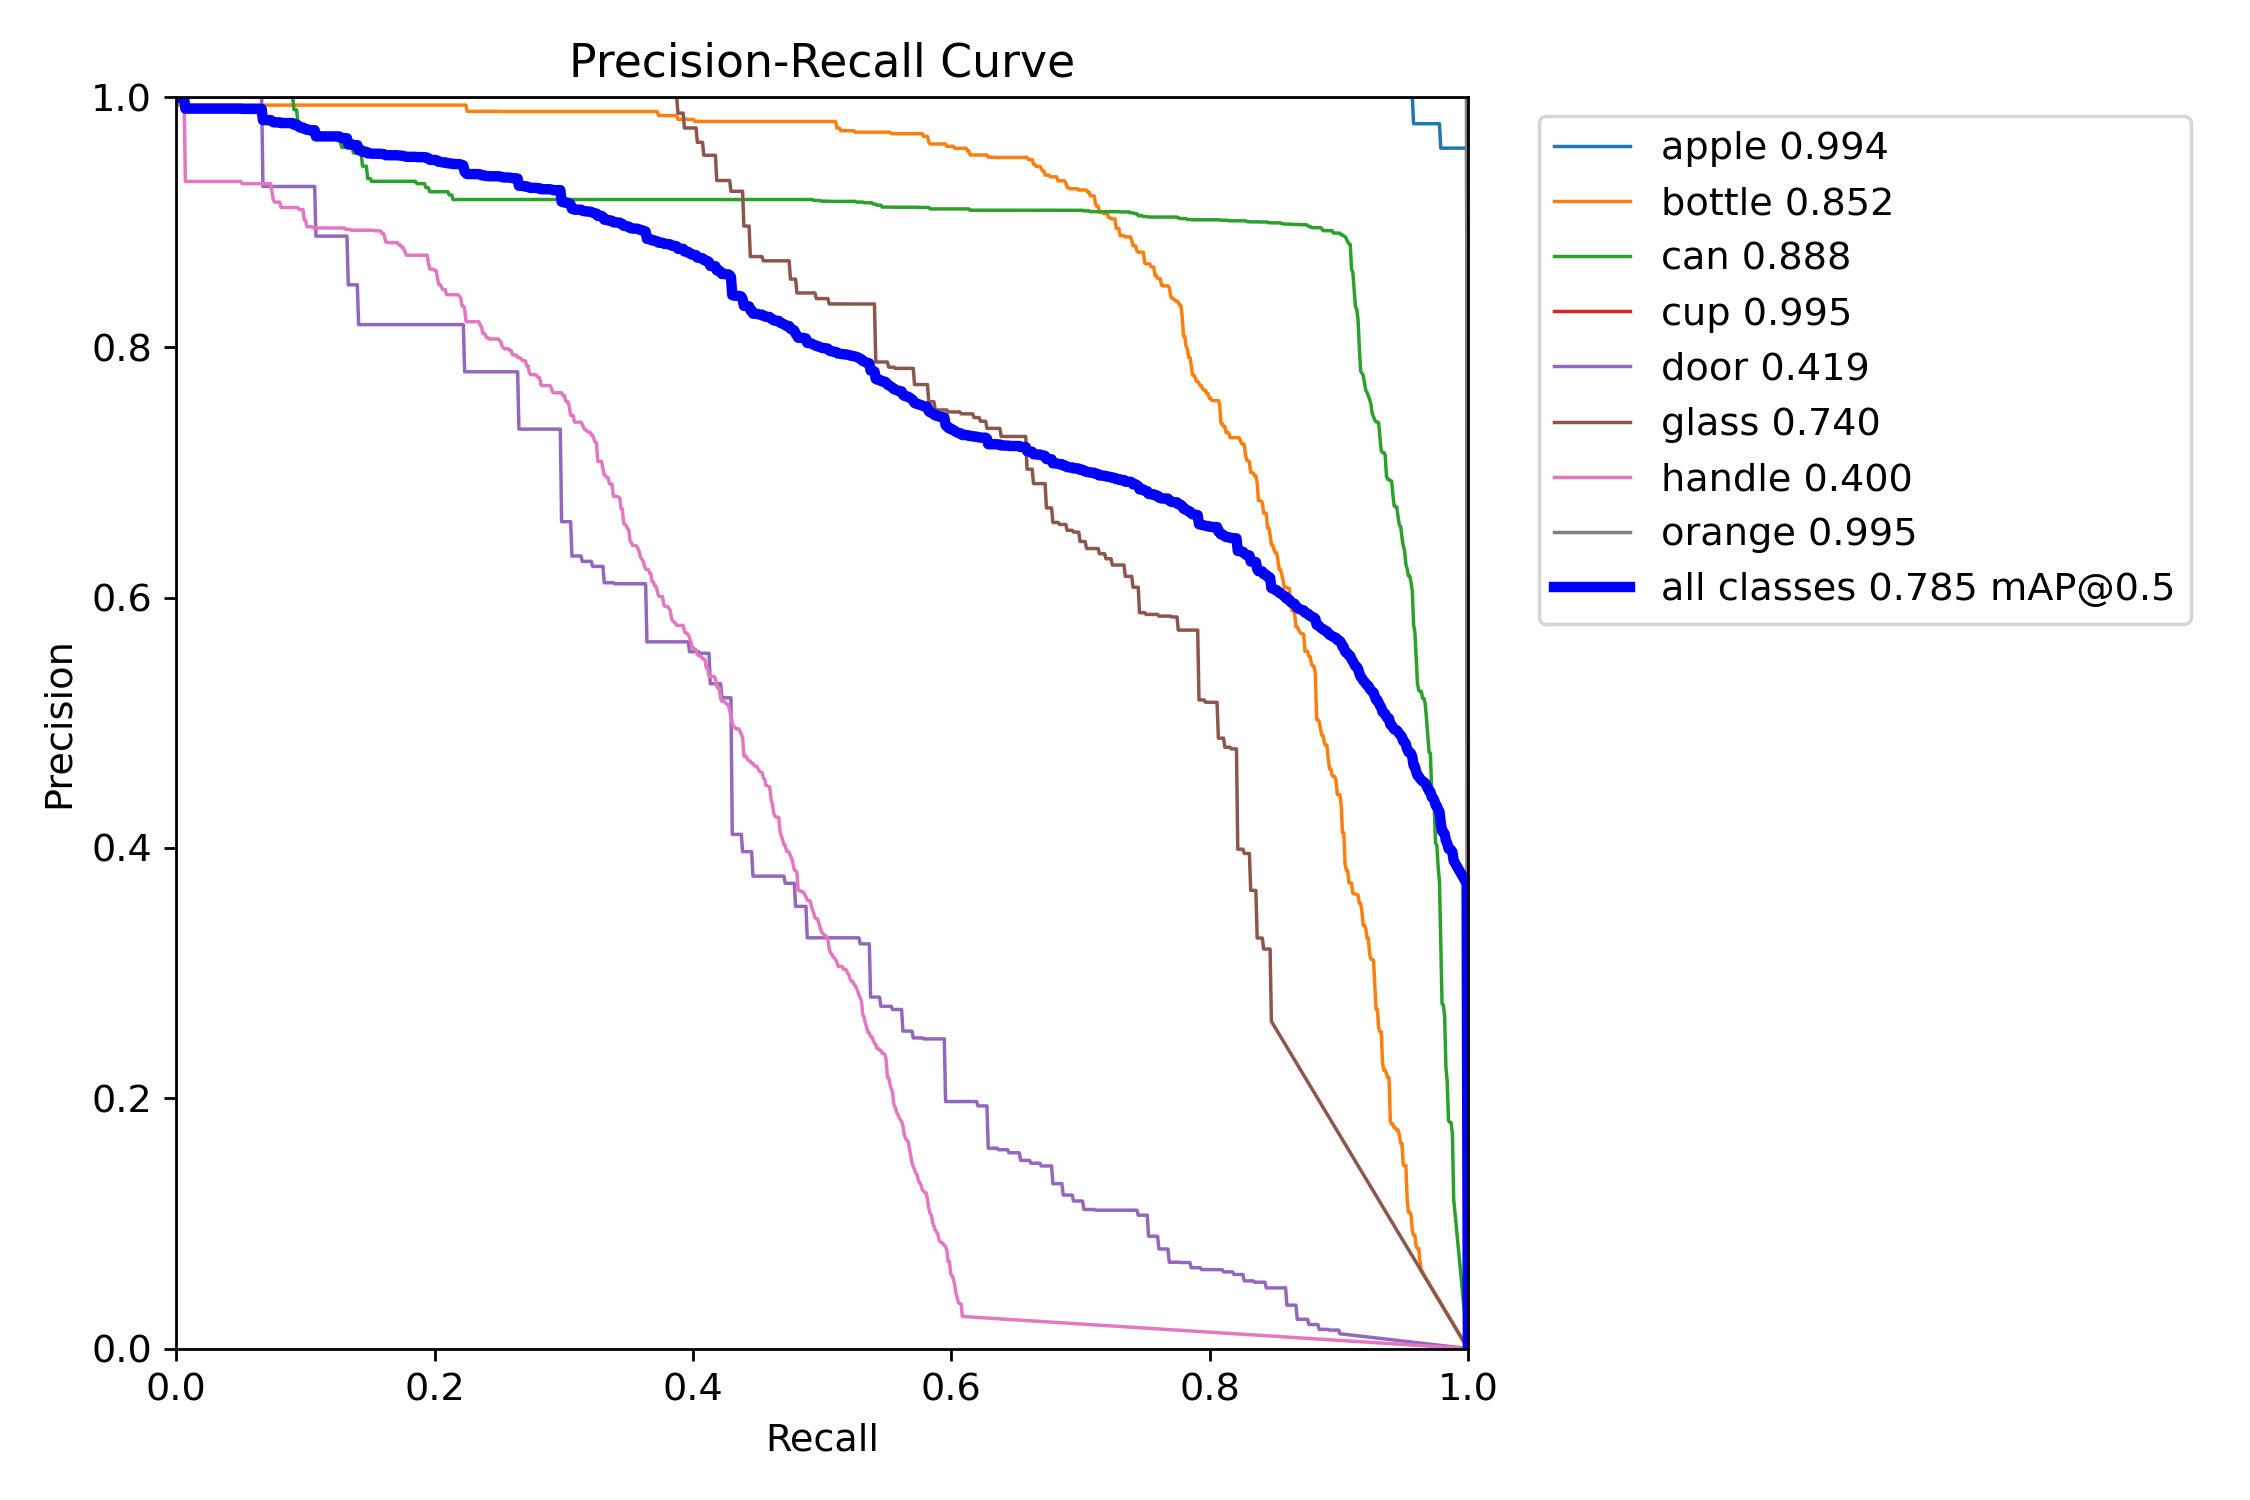

In [46]:
Image(f"{default_path}/runs/detect/train{ID}/PR_curve.png")

Add your comment here...

###### Step 0.3 Let's talk now about the dataset. What is indicates by the following figure?

First figure shows the number of instances for each class. -> imbalance in number of instances
Second figure shows the bounding boxes for each class.
Third figure shows the x, y coordinates of the center of the objects. -> most of them in the center of the image
Fourth figure shows the height, width of the objects. -> rather small objects

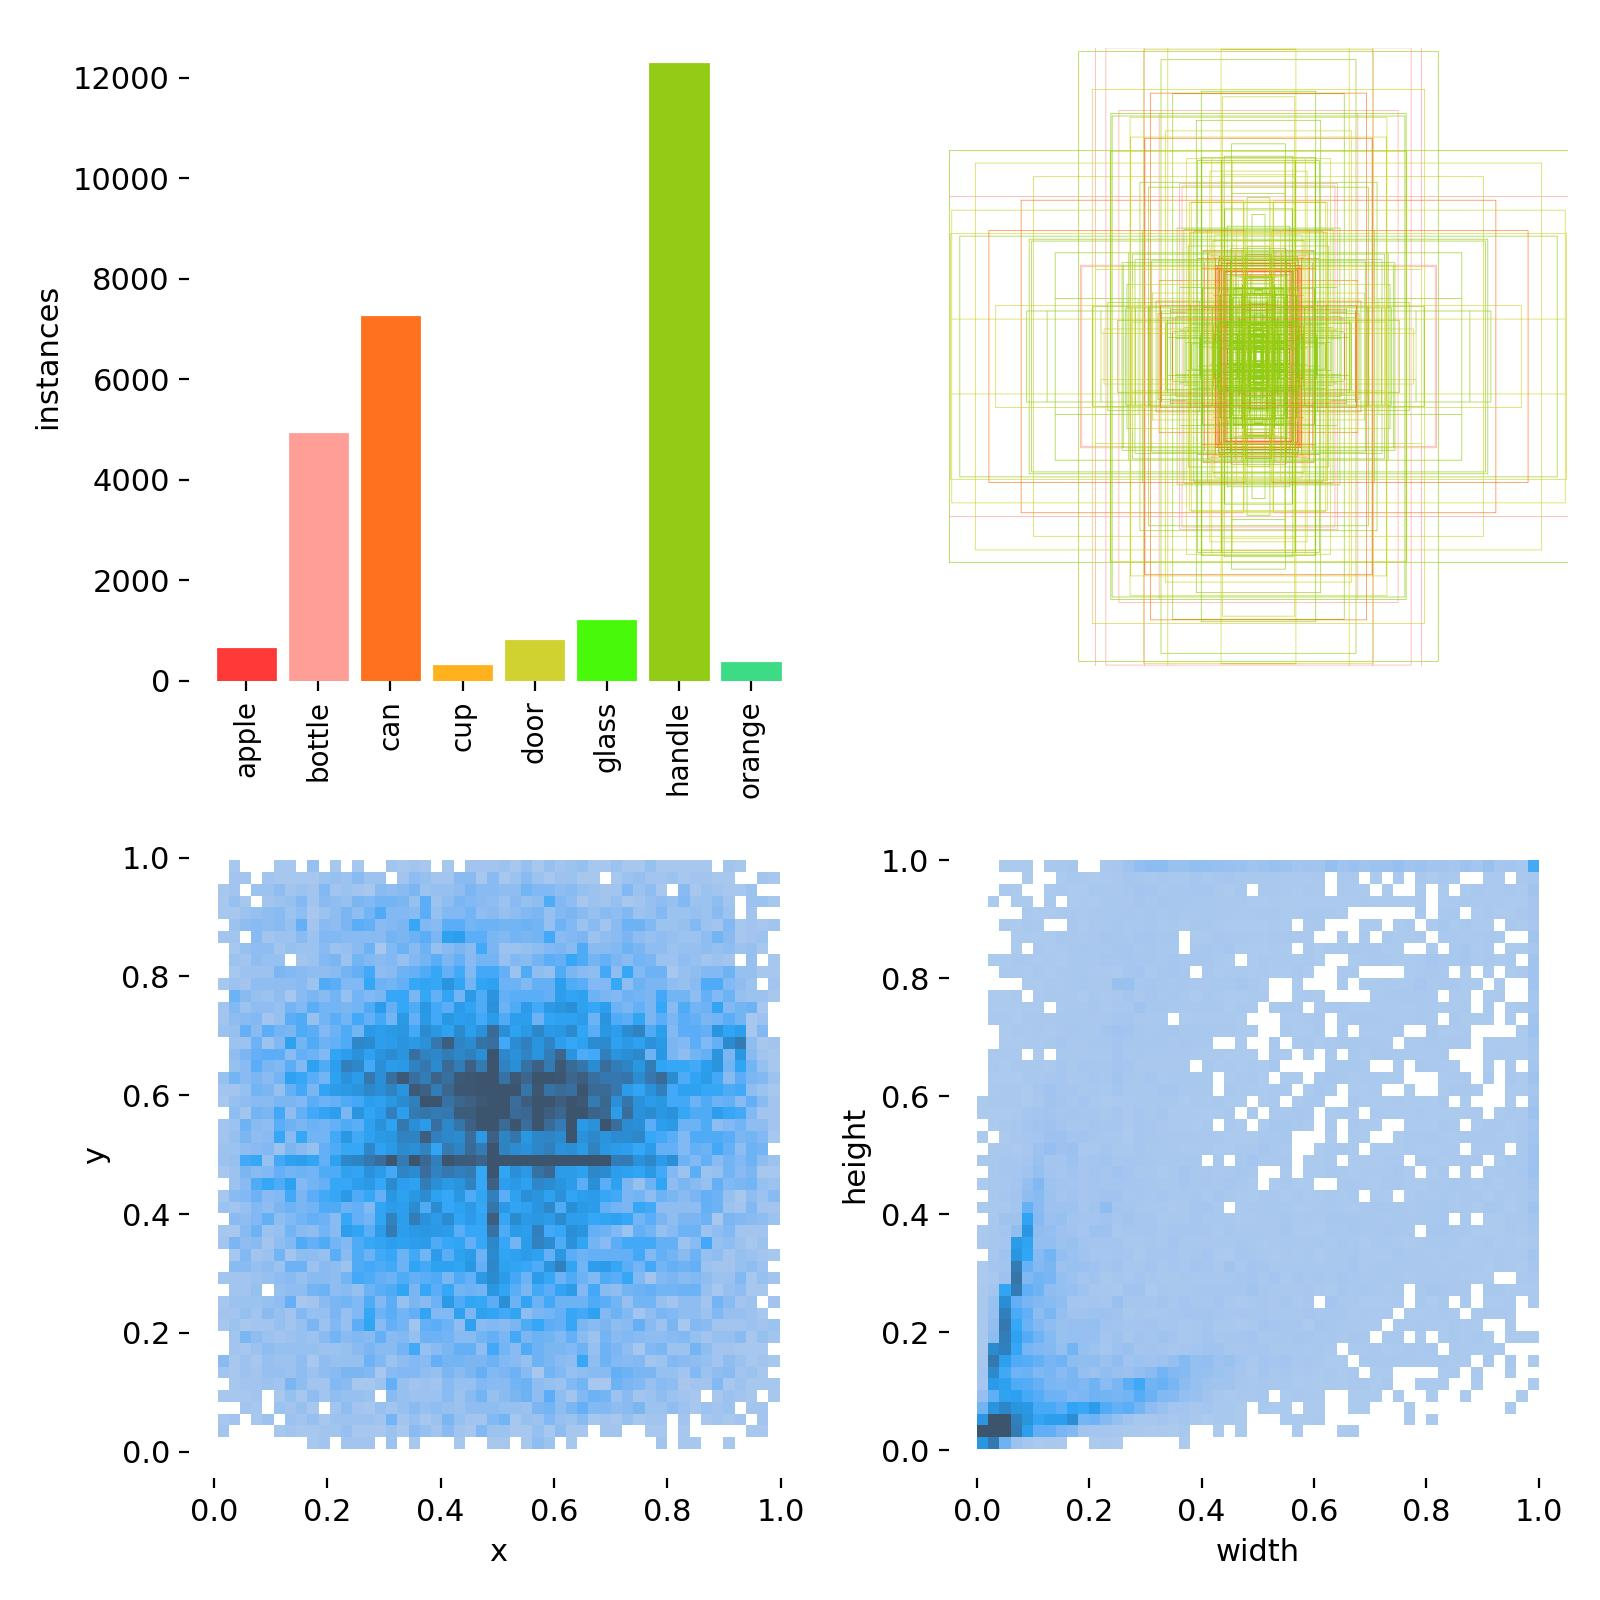

In [47]:
Image(f"{default_path}/runs/detect/train{ID}/labels.jpg")

Add your comment here...

###### Step 0.4 Please explain me the following image

Indicates how well the predicted labels match the true labels for the seperate classes.
Normalization helps with imbalance in number of instances per class.

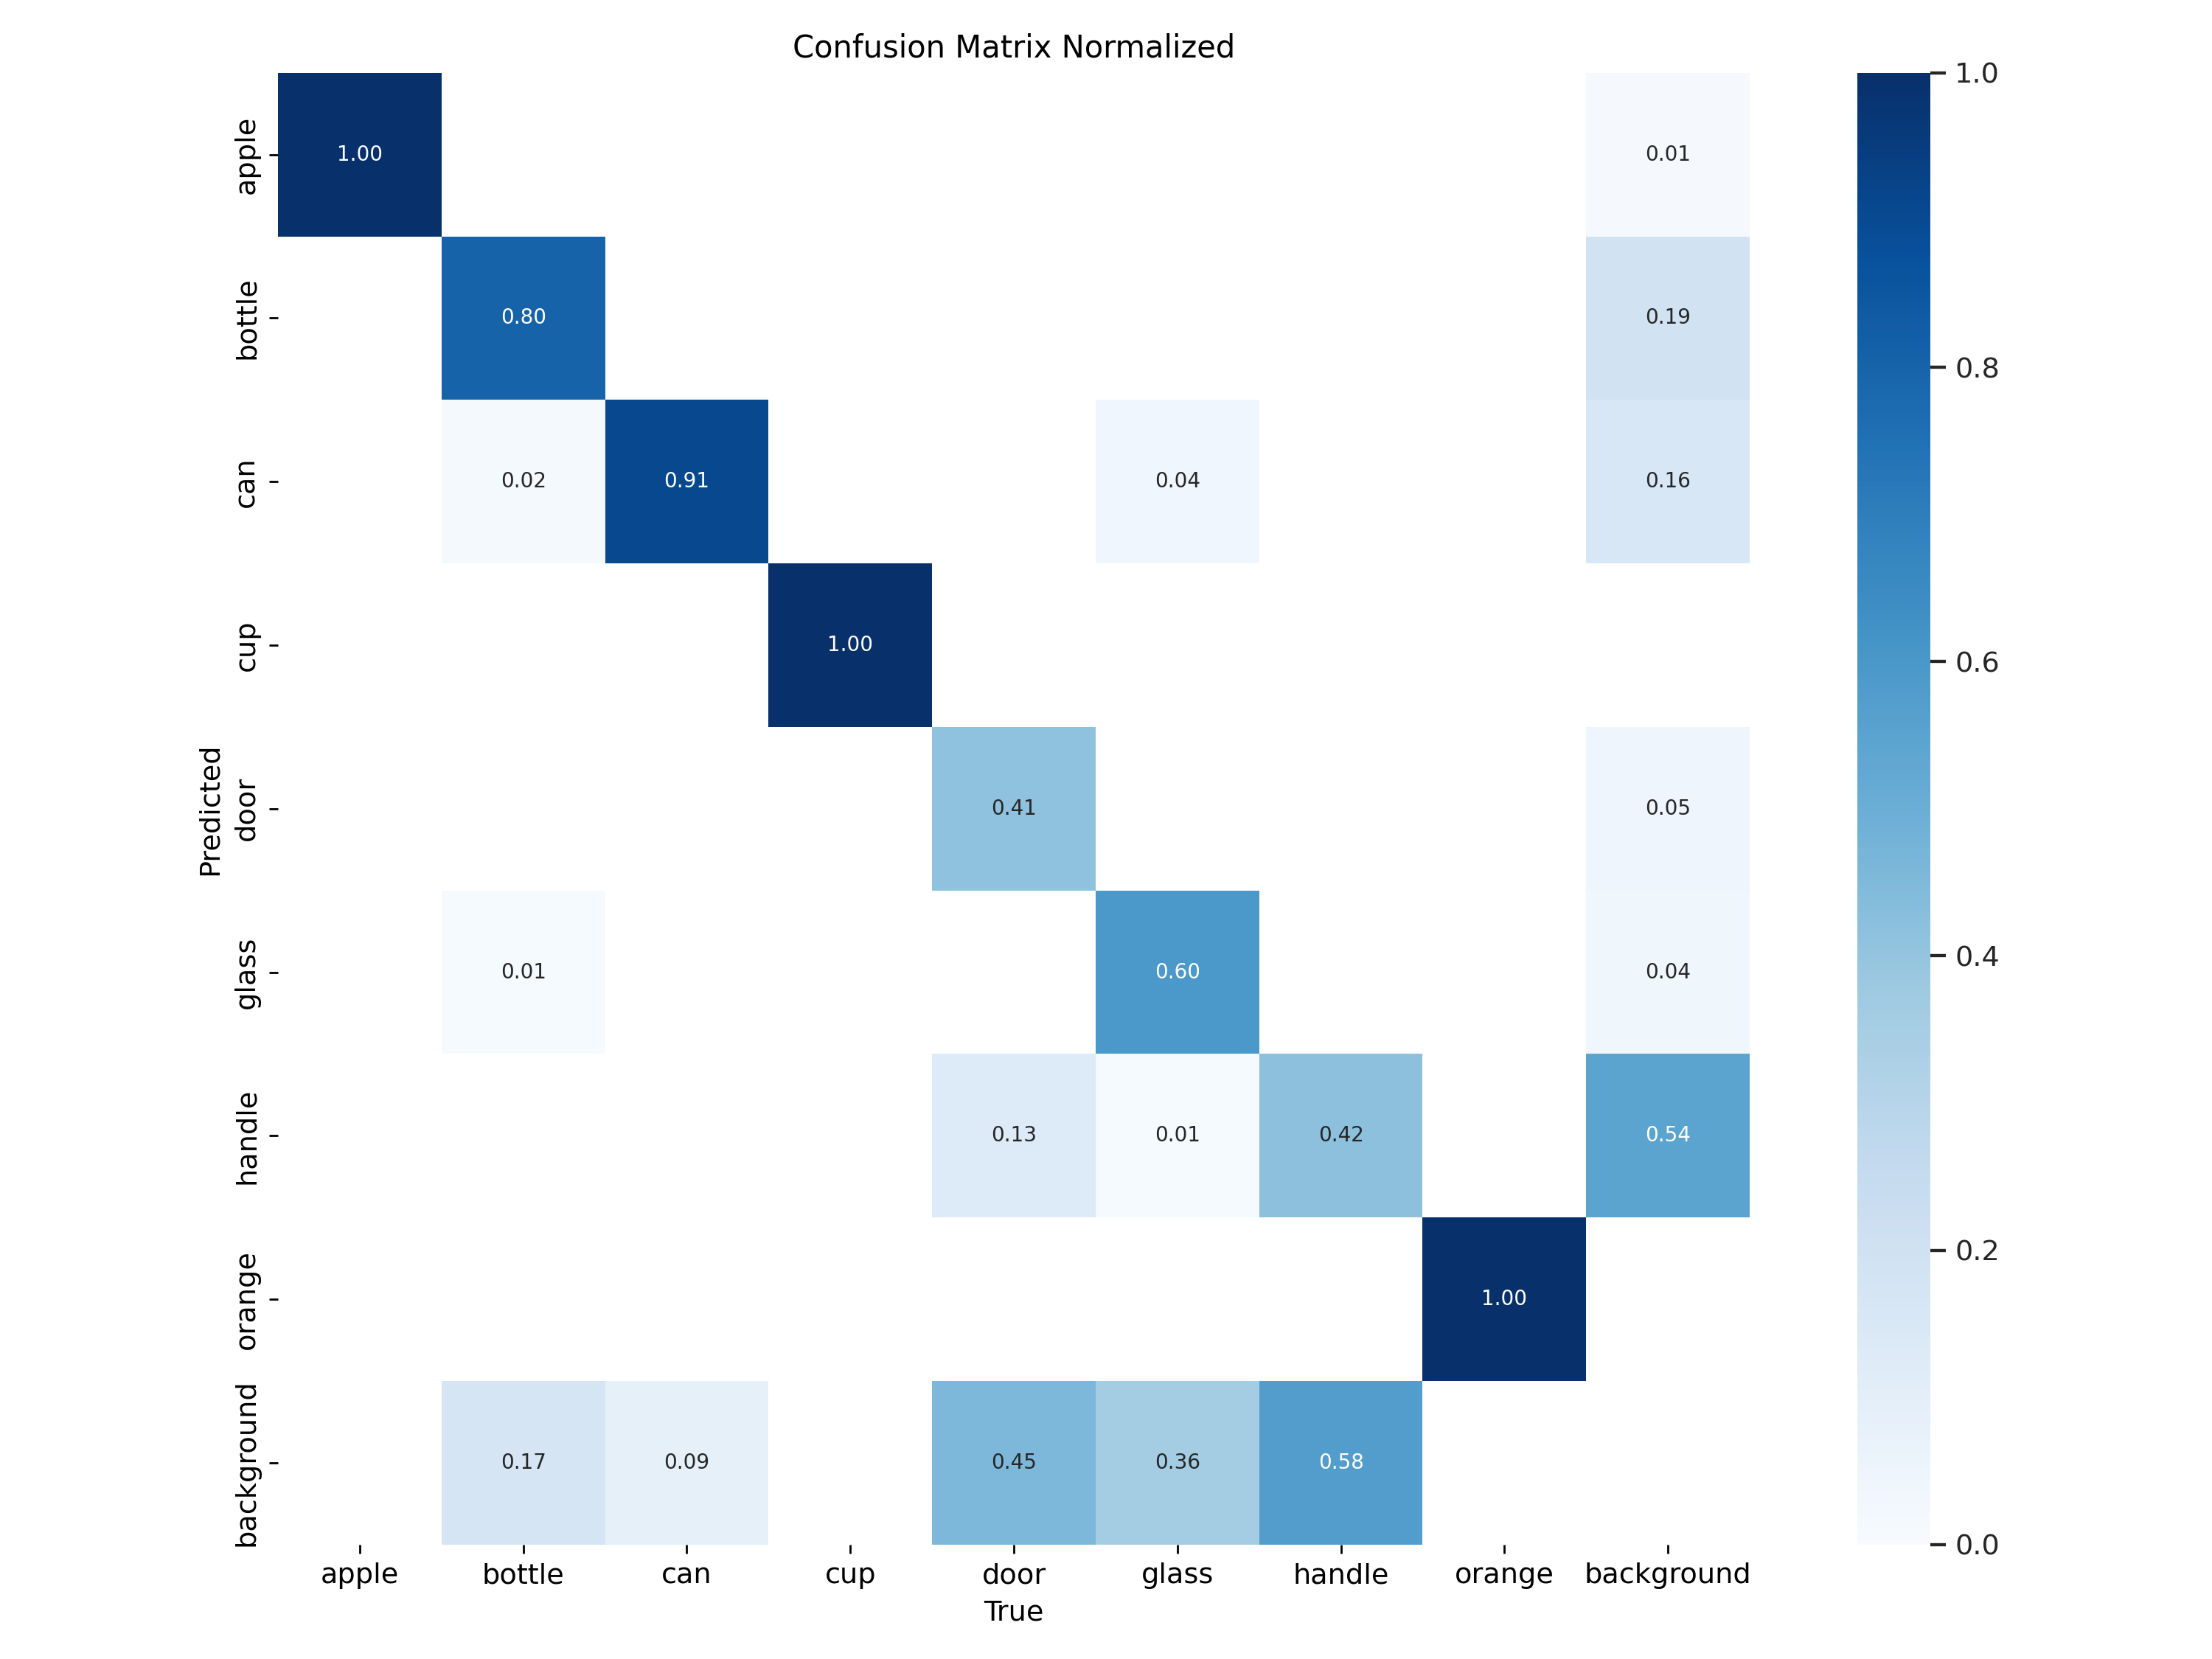

In [48]:
Image(f"{default_path}/runs/detect/train{ID}/confusion_matrix_normalized.png")

Add your comment here...

###### Finally, take a look at the validation ground truth and prediction.
Tune the epoch_num parameter depening on your training...

In [49]:
epoch_num = 2

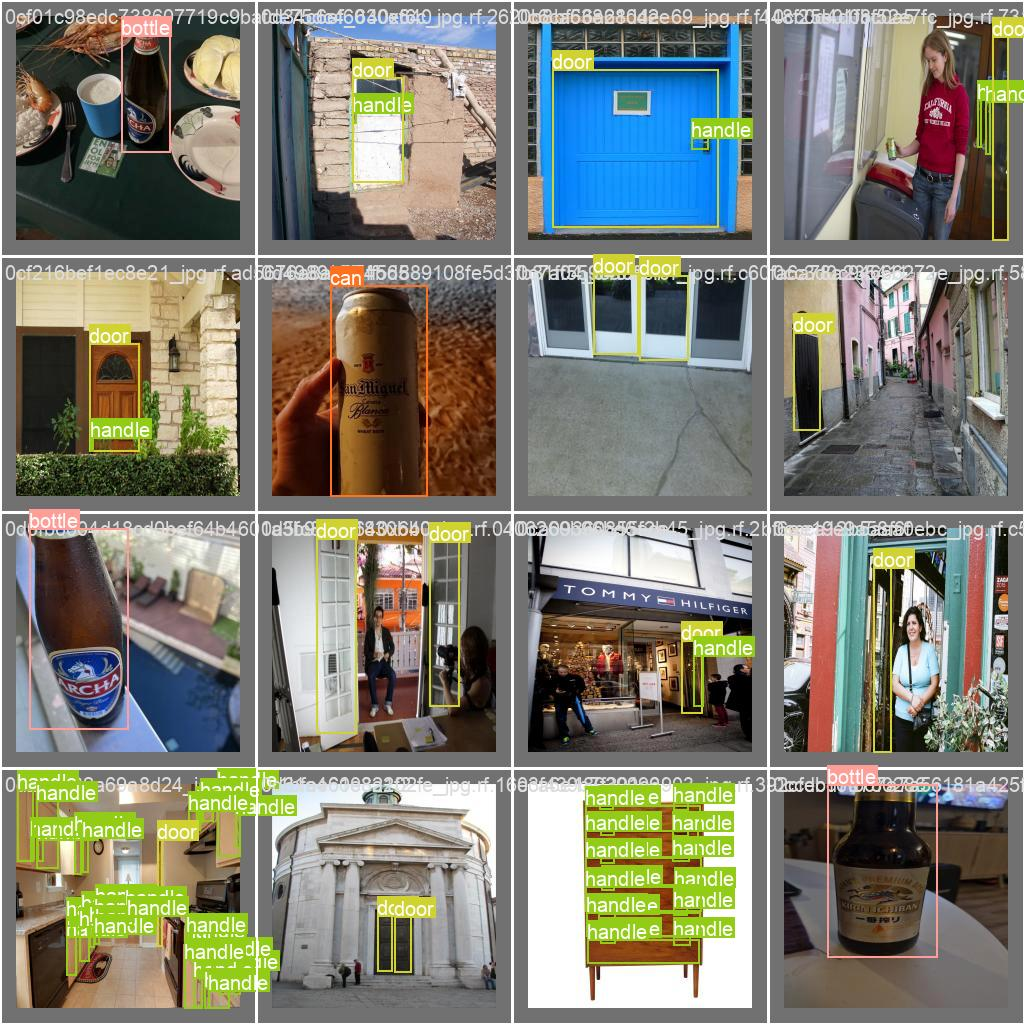

In [51]:
Image(f"{default_path}/runs/detect/train{ID}/val_batch{epoch_num}_labels.jpg")

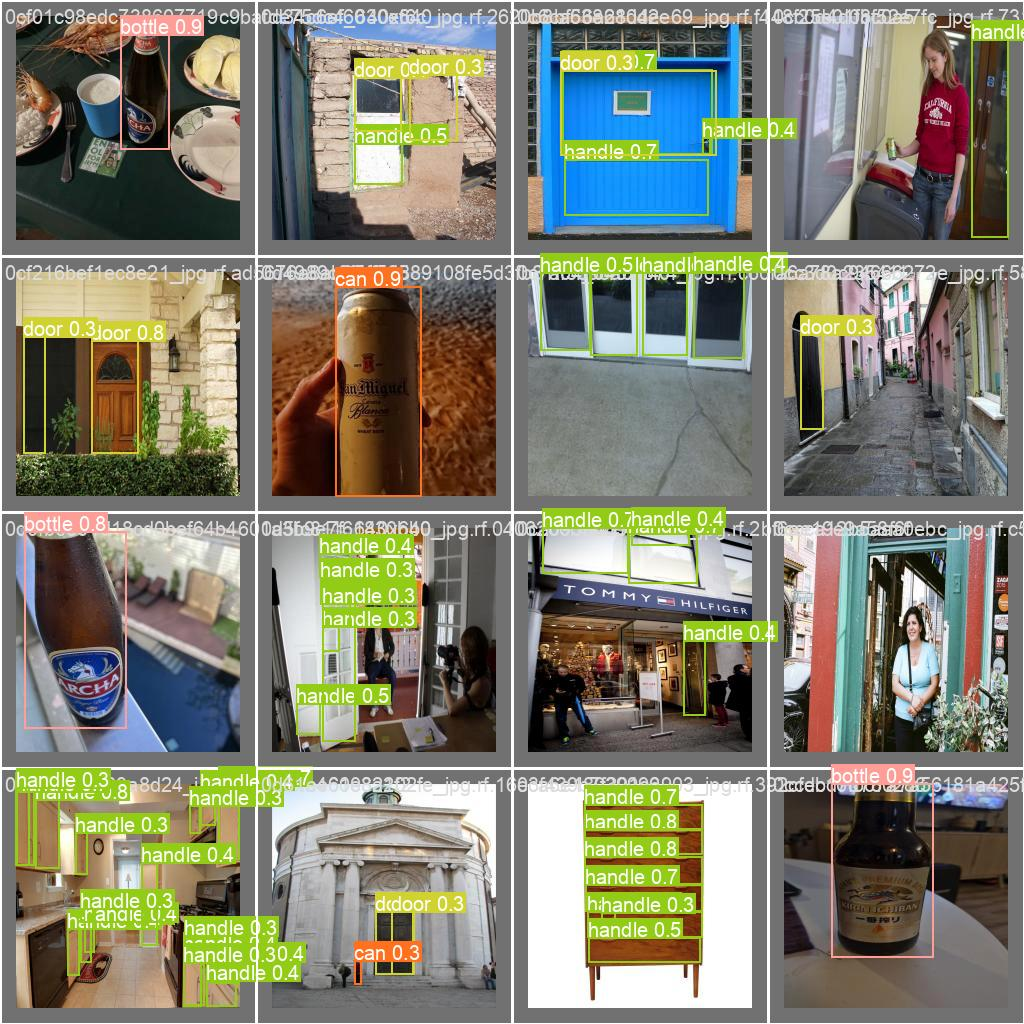

In [52]:
Image(f"{default_path}/runs/detect/train{ID}/val_batch{epoch_num}_pred.jpg")

##### Step 1. Load your trained model
Your trained model has been saved in the runs/train directory. Load this model in python and visualize the layers. Is there any difference compared to the pre-trained model previously shown?

In [1]:
from ultralytics import YOLO
import glob
import cv2
from IPython.display import Image

default_path = %pwd
ID = 0 # here add your trainID directory

yolowrapper = YOLO(f"{default_path}/runs/detect/train{ID}/weights/best.pt", task="inference") # As we want to train from scratch, we extract only the NN architecture, without additional functions
model = yolowrapper.model.model

In [2]:
print(model)

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C2f(
    (cv1): Conv(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
        

##### Step 2. Perform inference over a set of images
Load an image using cv2 or PIL libraries. Then, use your model to detect the objects from the images.
Create your custom function to draw the results into the image.
YOLO model has itself a wrapper to extract the results of the image. Obtain the confidence, bounding box, and class from the results and draw them in the image.

You can use the images provided or any custom one that includes the model is trained for.

In [6]:
def annotate_image(result):
    for idx in range(len(result.boxes)):
        boxes = result.boxes[idx]
        cls = result.names[int(boxes.cls.item())]
        x1, y1, x2, y2 = map(int, result.boxes[idx].xyxy[0])
        conf = boxes.conf.item()
        id = boxes.id

        cv2.rectangle(result.orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(result.orig_img, cls, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(0, 0 ,255), thickness=2)
        cv2.putText(result.orig_img, str(round(conf, 2)) + ' ' + str(id), (x1, y2), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(0, 0 ,255), thickness=2)

    return result.orig_img

In [7]:
import glob
import cv2
from IPython.display import Image

image_list = []
for filename in glob.glob(f"{default_path}/data/*.jpeg"):
    image_list.append(filename)

# img_path = f"{default_path}/data/KitchenASL_1.jpeg"

# img = cv2.imread(img_path)

results = yolowrapper(image_list)
img_idx = 0
idx = 0

for img_idx in range(len(results)):
    annotated_image = annotate_image(results[img_idx])
    cv2.imwrite(f"{default_path}/data/results/{img_idx}.jpeg", annotated_image)


0: 224x224 2 handles, 1: 224x224 3 handles, 2: 224x224 7 cans, 3: 224x224 5 cans, 1 handle, 147.8ms
Speed: 0.0ms preprocess, 36.9ms inference, 4.4ms postprocess per image at shape (1, 3, 224, 224)


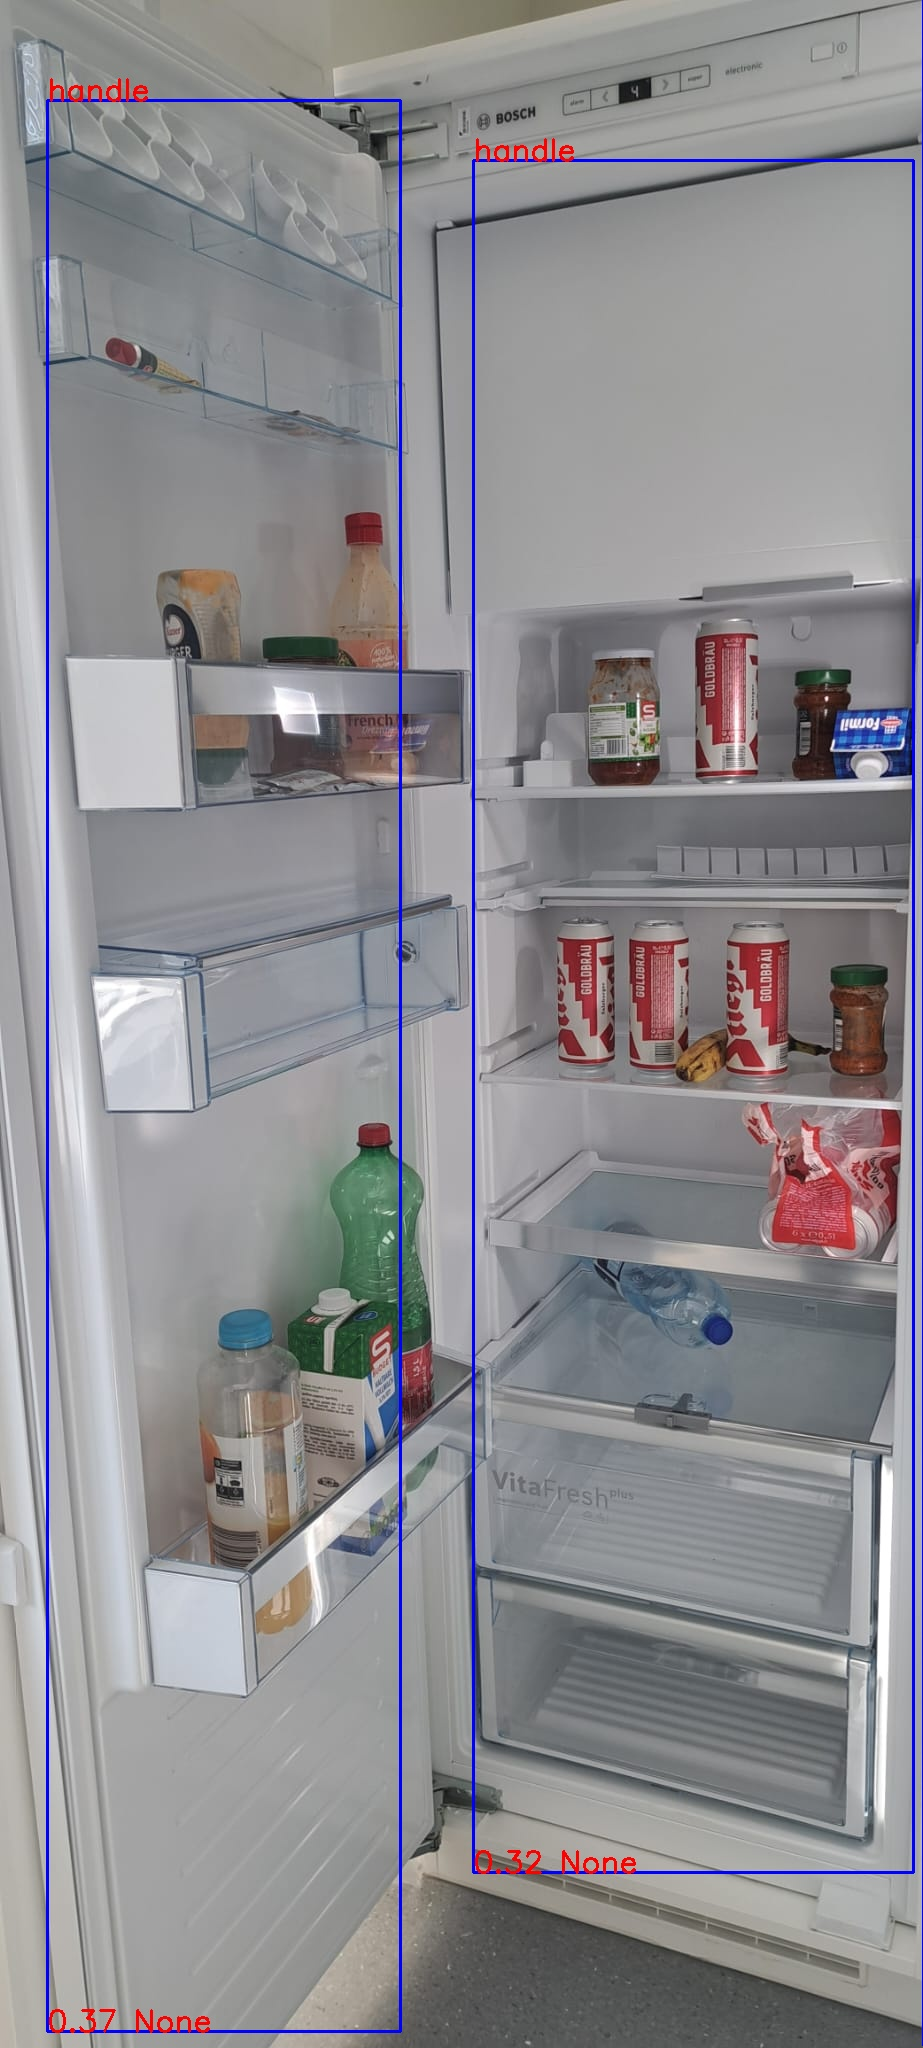

In [8]:
Image(f"{default_path}/data/results/1.jpeg")

##### Step 3. Use Yolov8 for object detection and tracking in videos
Take a look to the Ultralytics tutorials and check how to easily track objects in a video. 
Use your custom functions for loading the video and processing the video frame by frame.
Is there any difference in the results provided per each processed frames? Why?

In [10]:
### track id displayen
### vor allem in ros sollte man dann sehen ob er die cans richtig verfolgt

video_path = f"{default_path}/data/beer_tiago.mp4"
# results = yolowrapper.track(source=video_path, show=True)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')

cap = cv2.VideoCapture(video_path)
video = cv2.VideoWriter(f"{default_path}/data/results/video_annotated.mp4", fourcc, 20.0, (1920, 1080), True)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = yolowrapper.track(frame, persist=True, conf=0.4, iou=0.4, verbose=False)
        # print(results[0].orig_img.shape)

        # Visualize the results on the frame
        annotated_frame = annotate_image(results[0])
        video.write(annotated_frame)

        # Display the annotated frame
        cv2.imshow("YOLOv8 Tracking", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
video.release()
cv2.destroyAllWindows()

##### Step 4. Adapt the code to work on ROS
For simplification, we provide rosbags of beers and fridge handles
Call '''rosbag play FILENAME.bdg''' to play the bags (you can use RVIZ to visualize the content of those)

The exercise consists of playing the rosbag in one terminal. Write the code to read the RGB images from the rosbags, use your pre-trained model to detect the items, write those detected objects in an RGB image, and publish the draw image bag to ROS.

In [ ]:
# detect.py file

##### Step 5.  Learn how to obtain the 3D position from the object detection
For this case, you have to replay the data/TiagoGazebo_headmovement.bag , as it reproduces the Tiago moving the head in our Gazebo Simulated environment. The rosbag contains both RGB images and Depth information aligned, as well as the CameraInfo information for both RGB and Depth Cameras. Use those to obtain the 3D point of the can.

In [ ]:
# detect.py file

##### Step 6. Publish the results to ROS as a Marker, and Visualize the detected objects in RViz respect to the Robot Position

In [ ]:
# detect.py file